# CAD

In [1]:
# CAD Score Analysis for Art Styles
# This notebook calculates Concept Activation Direction (CAD) scores for Abstractionism against various art styles

import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pathlib import Path
from torch.nn.functional import cosine_similarity
import json
import warnings
warnings.filterwarnings('ignore')

# Import the necessary modules from your codebase
from omegaconf import OmegaConf
import sys
sys.path.append('/users/PAS2099/justinhylee135/Research/UnlearningDM/MMUC/machine_unlearning/mu_erasing_concept_esd')
from stable_diffusion.ldm.models.diffusion.ddim import DDIMSampler
from stable_diffusion.ldm.util import instantiate_from_config

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x14caab825d90>>
Traceback (most recent call last):
  File "/users/PAS2099/justinhylee135/anaconda3/envs/mmuc/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [ ]:
# Configuration
CONFIG_PATH = '/users/PAS2099/justinhylee135/Research/UnlearningDM/MMUC/machine_unlearning/mu_erasing_concept_esd/configs/train_esd.yaml'  # Update this path
CKPT_PATH = '/users/PAS2099/justinhylee135/Research/UnlearningDM/MMDU/external_model_ckpts/UnlearnCanvas/unlearncanvas_compvis.ckpt'  # Update this path
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
DDIM_STEPS = 50

# Art styles to analyze
TARGET_STYLE = "Abstractionism"
COMPARISON_STYLES = [
    "Blossom_Season",
    "Rust", 
    "Crayon",
    "Fauvism",
    "Superstring",
    "Red_Blue_Ink",
    "Gorgeous_Love",
    "French",
    "Joy",
    "Greenfield",
    "Expressionism",
    "Impressionism"
]

print(f"Target style: {TARGET_STYLE}")
print(f"Comparison styles: {len(COMPARISON_STYLES)} styles")
print(f"Device: {DEVICE}")

Target style: Abstractionism
Comparison styles: 12 styles
Device: cpu


In [ ]:
def load_model_from_config(config, ckpt, device="cpu", verbose=False):
    """Loads a model from config and a ckpt"""
    if isinstance(config, (str, Path)):
        config = OmegaConf.load(config)

    pl_sd = torch.load(ckpt, map_location="cpu")
    print(f"Loaded model from {ckpt}")
    global_step = pl_sd.get("global_step", 0)
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    model.to(device)
    model.eval()
    model.cond_stage_model.device = device
    return model

def format_style_name(style_name):
    """Convert style name to readable format"""
    return style_name.replace('_', ' ').title()

def format_prompt(style_name):
    """Format style name into a proper prompt"""
    formatted_name = format_style_name(style_name)
    return f"{formatted_name} Style"

def cad_get_score(model, cad_target, cad_anchor, cad_loss='cad', cad_device='cuda:0'):
    """Calculate CAD score and return gradient dictionary"""
    
    ddim_steps = DDIM_STEPS
    sampler = DDIMSampler(model)

    grad_dict = {}
    start_guidance = 3
    negative_guidance = 1.0
    
    # Create gradient dictionary 
    for name, param in model.model.diffusion_model.named_parameters():  
        if param.requires_grad:                                                                                                                 
            grad_dict[name] = 0
    
    # Get text embeddings
    with torch.no_grad():
        if isinstance(cad_target, str):
            cad_target_list = [cad_target]
        else:
            cad_target_list = cad_target
            
        if isinstance(cad_anchor, str):
            cad_anchor_list = [cad_anchor]
        else:
            cad_anchor_list = cad_anchor
            
        c_target = model.get_learned_conditioning(cad_target_list)
        c_anchor = model.get_learned_conditioning(cad_anchor_list)
        uc = model.get_learned_conditioning([""])
    
    # Create scheduler
    sampler.make_schedule(ddim_num_steps=ddim_steps, ddim_eta=0.0, verbose=False)

    # Prepare shape for sampling
    shape = [4, 512 // 8, 512 // 8]

    total_loss = 0.0
    
    # Iterate through timesteps
    for t_idx in tqdm(range(min(ddim_steps, len(sampler.ddim_timesteps))), 
                     desc=f"Computing gradients: {cad_target}", leave=False):
        with torch.no_grad():
            if t_idx == 0:
                img = torch.randn(1, *shape, device=cad_device)
                t_current = sampler.ddim_timesteps[0]
            else:
                subset_timesteps = sampler.ddim_timesteps[:t_idx+1]
                img = torch.randn(1, *shape, device=cad_device)
                
                for i, step in enumerate(subset_timesteps):
                    if i == len(subset_timesteps) - 1:
                        break

                    index = len(subset_timesteps) - i - 1
                    ts = torch.full((1,), step, device=cad_device, dtype=torch.long)
                    
                    img, _ = sampler.p_sample_ddim(
                        img, c_target, ts, index=index, 
                        use_original_steps=False,
                        unconditional_guidance_scale=start_guidance,
                        unconditional_conditioning=uc
                    )
                    
            t_current = sampler.ddim_timesteps[t_idx]
        
        timestep = torch.full((1,), t_current, device=cad_device, dtype=torch.long)
        img = img.detach().requires_grad_(True)
        
        model.model.diffusion_model.zero_grad()
    
        with torch.no_grad():
            noise_unconditional = model.apply_model(img, timestep, uc)
            noise_anchor = model.apply_model(img, timestep, c_anchor)

        with torch.enable_grad():
            noise_target = model.apply_model(img, timestep, c_target)
        
            if cad_loss == 'cad':
                obj = ((noise_target - noise_anchor.detach()) ** 2).sum()
            elif cad_loss == 'esd':
                criteria = torch.nn.MSELoss()
                reverse_cfg_noise = noise_unconditional - (negative_guidance * (noise_anchor - noise_unconditional))
                obj = criteria(noise_target, reverse_cfg_noise.detach())
            else:
                raise ValueError(f"Unsupported CAD loss type: {cad_loss}")
        
        obj.backward()
        total_loss += obj.item()
        
        # Accumulate gradients
        for name, param in model.model.diffusion_model.named_parameters():
            if param.grad is not None:
                grad_dict[name] += param.grad.detach().clone()
        
        model.model.diffusion_model.zero_grad()

    cad_score = np.sqrt(sum(torch.norm(grad).item() ** 2 for grad in grad_dict.values()))
    avg_loss = total_loss / len(sampler.ddim_timesteps)
    
    return cad_score, avg_loss, grad_dict

def save_grad_dict(style, grad_dict, output_dir="grad_dicts"):
    """Save gradient dictionary for a style"""
    os.makedirs(output_dir, exist_ok=True)
    safe_style_name = style.replace(' ', '_').replace('/', '_')
    grad_dict_file = os.path.join(output_dir, f"{safe_style_name}_grad_dict.pt")
    torch.save(grad_dict, grad_dict_file)
    return grad_dict_file

def load_grad_dict(style, output_dir="grad_dicts"):
    """Load existing gradient dictionary for a style"""
    safe_style_name = style.replace(' ', '_').replace('/', '_')
    grad_dict_file = os.path.join(output_dir, f"{safe_style_name}_grad_dict.pt")
    print(f"🔍 Checking for existing gradient dict for {style} at {grad_dict_file}")
    if os.path.exists(grad_dict_file):
        try:
            grad_dict = torch.load(grad_dict_file, map_location="cpu")
            print(f"📂 Loaded gradient dict for {style}")
            return grad_dict
        except Exception as e:
            print(f"⚠️  Error loading gradient dict for {style}: {e}")
            return None
    return None

def calculate_grad_dict_similarity(grad_dict1, grad_dict2, similarity_type='cosine'):
    """Calculate similarity between two gradient dictionaries"""
    
    # Flatten and concatenate all gradients
    def flatten_grad_dict(grad_dict):
        flattened = []
        for name in sorted(grad_dict.keys()):  # Sort for consistent ordering
            grad = grad_dict[name]
            if isinstance(grad, torch.Tensor):
                flattened.append(grad.flatten())
        return torch.cat(flattened) if flattened else torch.tensor([])
    
    vec1 = flatten_grad_dict(grad_dict1)
    vec2 = flatten_grad_dict(grad_dict2)
    
    if len(vec1) == 0 or len(vec2) == 0:
        return 0.0
    
    # Ensure same device
    vec1 = vec1.to(DEVICE)
    vec2 = vec2.to(DEVICE)
    
    if similarity_type == 'cosine':
        # Cosine similarity
        similarity = cosine_similarity(vec1.unsqueeze(0), vec2.unsqueeze(0))
        return float(similarity.cpu())
    
    elif similarity_type == 'l2_distance':
        # L2 distance (lower = more similar)
        distance = torch.norm(vec1 - vec2).item()
        return -distance  # Negative so higher = more similar
    
    elif similarity_type == 'pearson':
        # Pearson correlation
        vec1_centered = vec1 - vec1.mean()
        vec2_centered = vec2 - vec2.mean()
        correlation = torch.sum(vec1_centered * vec2_centered) / (torch.norm(vec1_centered) * torch.norm(vec2_centered))
        return float(correlation.cpu())
    
    else:
        raise ValueError(f"Unknown similarity type: {similarity_type}")

In [ ]:
# Load the diffusion model
print("Loading diffusion model...")
try:
    model = load_model_from_config(CONFIG_PATH, CKPT_PATH, DEVICE)
    print("Model loaded successfully!")
    
    # Set requires_grad for all parameters (needed for CAD calculation)
    for param in model.model.diffusion_model.parameters():
        param.requires_grad = True
        
except Exception as e:
    print(f"Error loading model: {e}")
    print("Please ensure the config and checkpoint paths are correct.")
    raise

Loading diffusion model...
Loaded model from /users/PAS2099/justinhylee135/Research/UnlearningDM/MMDU/external_model_ckpts/UnlearnCanvas/unlearncanvas_compvis.ckpt
Error loading model: No module named 'pytorch_lightning.utilities.distributed'
Please ensure the config and checkpoint paths are correct.


ModuleNotFoundError: No module named 'pytorch_lightning.utilities.distributed'


🔄 Computing gradient dictionaries for all styles...


Processing gradient dictionaries:   0%|                                                                                   | 0/13 [00:00<?, ?it/s]

🔍 Checking for existing gradient dict for Abstractionism at /users/PAS2099/justinhylee135/Research/UnlearningDM/CUIG/Analysis/Notebooks/cad_temp/Abstractionism_grad_dict.pt


Processing gradient dictionaries:   8%|█████▊                                                                     | 1/13 [00:00<00:07,  1.51it/s]

📂 Loaded gradient dict for Abstractionism
🔍 Checking for existing gradient dict for Blossom_Season at /users/PAS2099/justinhylee135/Research/UnlearningDM/CUIG/Analysis/Notebooks/cad_temp/Blossom_Season_grad_dict.pt


Processing gradient dictionaries:  15%|███████████▌                                                               | 2/13 [00:01<00:08,  1.34it/s]

📂 Loaded gradient dict for Blossom_Season
🔍 Checking for existing gradient dict for Rust at /users/PAS2099/justinhylee135/Research/UnlearningDM/CUIG/Analysis/Notebooks/cad_temp/Rust_grad_dict.pt


Processing gradient dictionaries:  23%|█████████████████▎                                                         | 3/13 [00:02<00:09,  1.11it/s]

📂 Loaded gradient dict for Rust
🔍 Checking for existing gradient dict for Crayon at /users/PAS2099/justinhylee135/Research/UnlearningDM/CUIG/Analysis/Notebooks/cad_temp/Crayon_grad_dict.pt


Processing gradient dictionaries:  31%|███████████████████████                                                    | 4/13 [00:03<00:09,  1.00s/it]

📂 Loaded gradient dict for Crayon
🔍 Checking for existing gradient dict for Fauvism at /users/PAS2099/justinhylee135/Research/UnlearningDM/CUIG/Analysis/Notebooks/cad_temp/Fauvism_grad_dict.pt


Processing gradient dictionaries:  38%|████████████████████████████▊                                              | 5/13 [00:04<00:08,  1.07s/it]

📂 Loaded gradient dict for Fauvism
🔍 Checking for existing gradient dict for Superstring at /users/PAS2099/justinhylee135/Research/UnlearningDM/CUIG/Analysis/Notebooks/cad_temp/Superstring_grad_dict.pt


Processing gradient dictionaries:  46%|██████████████████████████████████▌                                        | 6/13 [00:06<00:07,  1.10s/it]

📂 Loaded gradient dict for Superstring
🔍 Checking for existing gradient dict for Red_Blue_Ink at /users/PAS2099/justinhylee135/Research/UnlearningDM/CUIG/Analysis/Notebooks/cad_temp/Red_Blue_Ink_grad_dict.pt


Processing gradient dictionaries:  54%|████████████████████████████████████████▍                                  | 7/13 [00:07<00:06,  1.13s/it]

📂 Loaded gradient dict for Red_Blue_Ink
🔍 Checking for existing gradient dict for Gorgeous_Love at /users/PAS2099/justinhylee135/Research/UnlearningDM/CUIG/Analysis/Notebooks/cad_temp/Gorgeous_Love_grad_dict.pt


Processing gradient dictionaries:  62%|██████████████████████████████████████████████▏                            | 8/13 [00:08<00:05,  1.14s/it]

📂 Loaded gradient dict for Gorgeous_Love
🔍 Checking for existing gradient dict for French at /users/PAS2099/justinhylee135/Research/UnlearningDM/CUIG/Analysis/Notebooks/cad_temp/French_grad_dict.pt


Processing gradient dictionaries:  69%|███████████████████████████████████████████████████▉                       | 9/13 [00:14<00:10,  2.71s/it]

📂 Loaded gradient dict for French
🔍 Checking for existing gradient dict for Joy at /users/PAS2099/justinhylee135/Research/UnlearningDM/CUIG/Analysis/Notebooks/cad_temp/Joy_grad_dict.pt


Processing gradient dictionaries:  77%|████████████████████████████████████████████████████████▉                 | 10/13 [00:20<00:11,  3.80s/it]

📂 Loaded gradient dict for Joy
🔍 Checking for existing gradient dict for Greenfield at /users/PAS2099/justinhylee135/Research/UnlearningDM/CUIG/Analysis/Notebooks/cad_temp/Greenfield_grad_dict.pt


Processing gradient dictionaries:  85%|██████████████████████████████████████████████████████████████▌           | 11/13 [00:37<00:15,  7.61s/it]

📂 Loaded gradient dict for Greenfield
🔍 Checking for existing gradient dict for Expressionism at /users/PAS2099/justinhylee135/Research/UnlearningDM/CUIG/Analysis/Notebooks/cad_temp/Expressionism_grad_dict.pt


Processing gradient dictionaries:  92%|████████████████████████████████████████████████████████████████████▎     | 12/13 [00:43<00:07,  7.12s/it]

📂 Loaded gradient dict for Expressionism
🔍 Checking for existing gradient dict for Impressionism at /users/PAS2099/justinhylee135/Research/UnlearningDM/CUIG/Analysis/Notebooks/cad_temp/Impressionism_grad_dict.pt


Processing gradient dictionaries: 100%|██████████████████████████████████████████████████████████████████████████| 13/13 [00:53<00:00,  4.13s/it]

📂 Loaded gradient dict for Impressionism

✅ Successfully loaded/computed 13 gradient dictionaries

📊 Calculating gradient similarities to Abstractionism...


✅ Blossom_Season: Cosine=0.1674, L2=-2.02e+05, Pearson=0.1674
✅ Rust: Cosine=0.2559, L2=-1.85e+05, Pearson=0.2559
✅ Crayon: Cosine=0.4976, L2=-2.09e+05, Pearson=0.4976
✅ Fauvism: Cosine=0.4841, L2=-1.80e+05, Pearson=0.4841
✅ Superstring: Cosine=0.3639, L2=-2.09e+05, Pearson=0.3639
✅ Red_Blue_Ink: Cosine=0.6142, L2=-1.52e+05, Pearson=0.6142
✅ Gorgeous_Love: Cosine=0.5500, L2=-1.51e+05, Pearson=0.5500
✅ French: Cosine=0.3063, L2=-1.75e+05, Pearson=0.3063
✅ Joy: Cosine=0.4057, L2=-1.71e+05, Pearson=0.4057
✅ Greenfield: Cosine=0.5559, L2=-1.51e+05, Pearson=0.5559
✅ Expressionism: Cosine=0.5143, L2=-1.74e+05, Pearson=0.5143
✅ Impressionism: Cosine=0.4512, L2=-1.66e+05, Pearson=0.4512

🎯 STYLES RANKED BY GRADIENT SIMILARITY TO Abstractionism
Ranking based on cosine similarity of gradient activation patterns
Higher cosine similarity = More similar activation patterns
 1. Red Blue Ink         | Cosine:  0.6142 | L2: -1.52e+05 | Pearson:  0.6142
 2. Greenfield           | Cosine:  0.5559 | L2: 

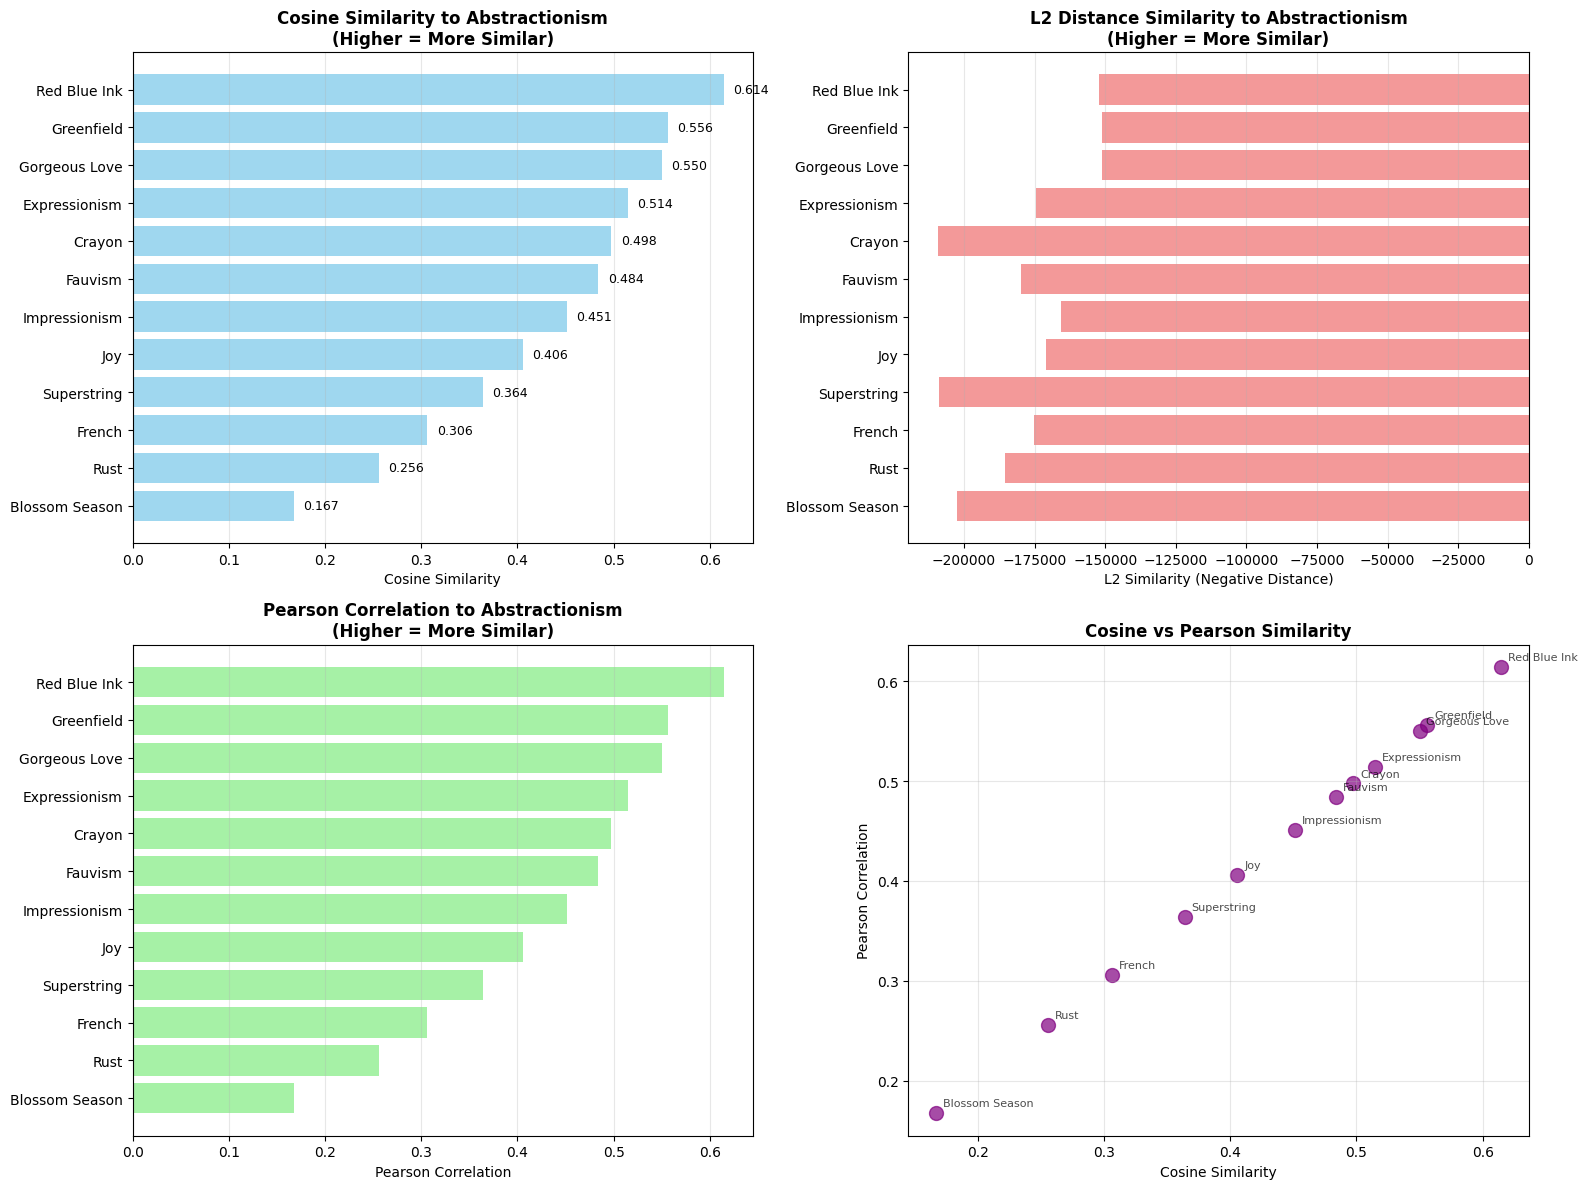


📈 SUMMARY STATISTICS
Most similar style (Cosine):     Red Blue Ink (0.6142)
Least similar style (Cosine):    Blossom Season (0.1674)
Average cosine similarity:       0.4305
Std dev cosine similarity:       0.1344

Correlation between metrics:
Cosine vs Pearson:              1.0000
Cosine vs L2:                   0.6065

💾 Results saved to: gradient_similarity_to_abstractionism.json
📁 Gradient dictionaries saved in: /users/PAS2099/justinhylee135/Research/UnlearningDM/CUIG/Analysis/Notebooks/cad_temp/

✅ GRADIENT SIMILARITY ANALYSIS COMPLETE!
🥇 Most similar to Abstractionism: Red Blue Ink
🥈 Second most similar: Greenfield
🥉 Third most similar: Gorgeous Love


In [ ]:
# Get or compute gradient dictionaries
print(f"\n🔄 Computing gradient dictionaries for all styles...")

all_styles = [TARGET_STYLE] + COMPARISON_STYLES
grad_dicts = {}
output_dir = "/users/PAS2099/justinhylee135/Research/UnlearningDM/CUIG/Analysis/Notebooks/cad_temp"

for style in tqdm(all_styles, desc="Processing gradient dictionaries"):
    try:
        # Try to load existing gradient dictionary
        grad_dict = load_grad_dict(style, output_dir)
        
        if grad_dict is None:
            # Compute new gradient dictionary
            target_prompt = format_prompt(style)
            anchor_prompt = ""
            
            print(f"\n🔄 Computing gradient dict for '{target_prompt}' vs '{anchor_prompt}'")
            
            cad_score, avg_loss, grad_dict = cad_get_score(
                model=model,
                cad_target=target_prompt,
                cad_anchor=anchor_prompt,
                cad_loss='cad',
                cad_device=DEVICE
            )
            
            # Move to CPU and save
            grad_dict = {name: tensor.cpu() if isinstance(tensor, torch.Tensor) else tensor 
                        for name, tensor in grad_dict.items()}
            torch.cuda.empty_cache()
            
            # Save for future use
            save_grad_dict(style, grad_dict, output_dir)
            print(f"✅ Computed and saved gradient dict for {style}")
        
        grad_dicts[style] = grad_dict
        
    except Exception as e:
        print(f"✗ Error processing gradient dict for {style}: {e}")
        continue

print(f"\n✅ Successfully loaded/computed {len(grad_dicts)} gradient dictionaries")

# Calculate similarities to Abstractionism
if TARGET_STYLE not in grad_dicts:
    print(f"❌ Error: Could not compute gradient dictionary for {TARGET_STYLE}")
    exit()

target_grad_dict = grad_dicts[TARGET_STYLE]
similarities = []

print(f"\n📊 Calculating gradient similarities to {TARGET_STYLE}...")

for style in COMPARISON_STYLES:
    if style not in grad_dicts:
        print(f"⚠️  Skipping {style} - no gradient dictionary available")
        continue
    
    try:
        # Calculate multiple similarity metrics
        cosine_sim = calculate_grad_dict_similarity(target_grad_dict, grad_dicts[style], 'cosine')
        l2_sim = calculate_grad_dict_similarity(target_grad_dict, grad_dicts[style], 'l2_distance')
        pearson_sim = calculate_grad_dict_similarity(target_grad_dict, grad_dicts[style], 'pearson')
        
        similarities.append({
            'style': format_style_name(style),
            'raw_style': style,
            'cosine_similarity': cosine_sim,
            'l2_similarity': l2_sim,
            'pearson_correlation': pearson_sim
        })
        
        print(f"✅ {style}: Cosine={cosine_sim:.4f}, L2={l2_sim:.2e}, Pearson={pearson_sim:.4f}")
        
    except Exception as e:
        print(f"✗ Error calculating similarity for {style}: {e}")
        continue

# Create results DataFrame and rank by cosine similarity
df_similarities = pd.DataFrame(similarities)
df_similarities = df_similarities.sort_values('cosine_similarity', ascending=False).reset_index(drop=True)

# Display results
print(f"\n🎯 STYLES RANKED BY GRADIENT SIMILARITY TO {TARGET_STYLE}")
print("=" * 80)
print("Ranking based on cosine similarity of gradient activation patterns")
print("Higher cosine similarity = More similar activation patterns")
print("=" * 80)

for idx, row in df_similarities.iterrows():
    print(f"{idx+1:2d}. {row['style']:20s} | "
          f"Cosine: {row['cosine_similarity']:7.4f} | "
          f"L2: {row['l2_similarity']:8.2e} | "
          f"Pearson: {row['pearson_correlation']:7.4f}")

# Visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Cosine similarity bar plot
bars1 = ax1.barh(range(len(df_similarities)), df_similarities['cosine_similarity'], 
                 color='skyblue', alpha=0.8)
ax1.set_yticks(range(len(df_similarities)))
ax1.set_yticklabels(df_similarities['style'])
ax1.invert_yaxis()
ax1.set_title(f'Cosine Similarity to {TARGET_STYLE}\n(Higher = More Similar)', fontweight='bold')
ax1.set_xlabel('Cosine Similarity')
ax1.grid(axis='x', alpha=0.3)

# Add value labels
for i, (idx, row) in enumerate(df_similarities.iterrows()):
    ax1.text(row['cosine_similarity'] + 0.01, i, f'{row["cosine_similarity"]:.3f}', 
             va='center', fontsize=9)

# L2 similarity bar plot
bars2 = ax2.barh(range(len(df_similarities)), df_similarities['l2_similarity'], 
                 color='lightcoral', alpha=0.8)
ax2.set_yticks(range(len(df_similarities)))
ax2.set_yticklabels(df_similarities['style'])
ax2.invert_yaxis()
ax2.set_title(f'L2 Distance Similarity to {TARGET_STYLE}\n(Higher = More Similar)', fontweight='bold')
ax2.set_xlabel('L2 Similarity (Negative Distance)')
ax2.grid(axis='x', alpha=0.3)

# Pearson correlation bar plot
bars3 = ax3.barh(range(len(df_similarities)), df_similarities['pearson_correlation'], 
                 color='lightgreen', alpha=0.8)
ax3.set_yticks(range(len(df_similarities)))
ax3.set_yticklabels(df_similarities['style'])
ax3.invert_yaxis()
ax3.set_title(f'Pearson Correlation to {TARGET_STYLE}\n(Higher = More Similar)', fontweight='bold')
ax3.set_xlabel('Pearson Correlation')
ax3.grid(axis='x', alpha=0.3)

# Correlation between metrics
ax4.scatter(df_similarities['cosine_similarity'], df_similarities['pearson_correlation'], 
           alpha=0.7, s=100, color='purple')
ax4.set_xlabel('Cosine Similarity')
ax4.set_ylabel('Pearson Correlation')
ax4.set_title('Cosine vs Pearson Similarity', fontweight='bold')
ax4.grid(alpha=0.3)

# Add style labels to scatter plot
for idx, row in df_similarities.iterrows():
    ax4.annotate(row['style'], 
                (row['cosine_similarity'], row['pearson_correlation']),
                xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.7)

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\n📈 SUMMARY STATISTICS")
print("=" * 50)
print(f"Most similar style (Cosine):     {df_similarities.iloc[0]['style']} ({df_similarities.iloc[0]['cosine_similarity']:.4f})")
print(f"Least similar style (Cosine):    {df_similarities.iloc[-1]['style']} ({df_similarities.iloc[-1]['cosine_similarity']:.4f})")
print(f"Average cosine similarity:       {df_similarities['cosine_similarity'].mean():.4f}")
print(f"Std dev cosine similarity:       {df_similarities['cosine_similarity'].std():.4f}")

# Correlation between similarity metrics
cosine_pearson_corr = df_similarities['cosine_similarity'].corr(df_similarities['pearson_correlation'])
cosine_l2_corr = df_similarities['cosine_similarity'].corr(df_similarities['l2_similarity'])

print(f"\nCorrelation between metrics:")
print(f"Cosine vs Pearson:              {cosine_pearson_corr:.4f}")
print(f"Cosine vs L2:                   {cosine_l2_corr:.4f}")

# Save results
output_file = f"gradient_similarity_to_{TARGET_STYLE.lower()}.json"
output_data = {
    'analysis_type': 'gradient_dictionary_similarity',
    'target_style': TARGET_STYLE,
    'comparison_styles': COMPARISON_STYLES,
    'analysis_date': pd.Timestamp.now().isoformat(),
    'model_config': CONFIG_PATH,
    'model_checkpoint': CKPT_PATH,
    'device': DEVICE,
    'ddim_steps': DDIM_STEPS,
    'similarity_metrics': ['cosine_similarity', 'l2_similarity', 'pearson_correlation'],
    'ranking_by_cosine_similarity': df_similarities.to_dict('records'),
    'summary_stats': {
        'most_similar': {
            'style': df_similarities.iloc[0]['style'],
            'cosine_similarity': float(df_similarities.iloc[0]['cosine_similarity'])
        },
        'least_similar': {
            'style': df_similarities.iloc[-1]['style'],
            'cosine_similarity': float(df_similarities.iloc[-1]['cosine_similarity'])
        },
        'average_cosine_similarity': float(df_similarities['cosine_similarity'].mean()),
        'std_cosine_similarity': float(df_similarities['cosine_similarity'].std()),
        'cosine_pearson_correlation': float(cosine_pearson_corr),
        'cosine_l2_correlation': float(cosine_l2_corr)
    }
}

with open(output_file, 'w') as f:
    json.dump(output_data, f, indent=2)

print(f"\n💾 Results saved to: {output_file}")
print(f"📁 Gradient dictionaries saved in: {output_dir}/")

print(f"\n✅ GRADIENT SIMILARITY ANALYSIS COMPLETE!")
print(f"🥇 Most similar to {TARGET_STYLE}: {df_similarities.iloc[0]['style']}")
print(f"🥈 Second most similar: {df_similarities.iloc[1]['style']}")
print(f"🥉 Third most similar: {df_similarities.iloc[2]['style']}")

# Text Embedding

In [2]:
# Text Embedding Similarity Analysis
# This notebook analyzes similarity between text embeddings for art styles

import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pathlib import Path
import json
import os
from torch.nn.functional import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Import the necessary modules from your codebase
from omegaconf import OmegaConf
import sys
sys.path.append('/users/PAS2099/justinhylee135/Research/UnlearningDM/MMUC/machine_unlearning/mu_erasing_concept_esd')
from stable_diffusion.ldm.models.diffusion.ddim import DDIMSampler
from stable_diffusion.ldm.util import instantiate_from_config

print("Environment setup complete!")

# Configuration
CONFIG_PATH = '/users/PAS2099/justinhylee135/Research/UnlearningDM/MMUC/machine_unlearning/mu_erasing_concept_esd/configs/train_esd.yaml'  # Update this path
CKPT_PATH = '/users/PAS2099/justinhylee135/Research/UnlearningDM/MMDU/external_model_ckpts/UnlearnCanvas/unlearncanvas_compvis.ckpt'  # Update this path
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Art styles to analyze
TARGET_STYLE = "Abstractionism"
COMPARISON_STYLES = [
    "Blossom_Season",
    "Rust", 
    "Crayon",
    "Fauvism",
    "Superstring",
    "Red_Blue_Ink",
    "Gorgeous_Love",
    "French",
    "Joy",
    "Greenfield",
    "Expressionism",
    "Impressionism"
]

print(f"Target style: {TARGET_STYLE}")
print(f"Comparison styles: {len(COMPARISON_STYLES)} styles")
print(f"Device: {DEVICE}")

print("\n" + "="*70)
print("📋 TEXT EMBEDDING SIMILARITY ANALYSIS")
print("="*70)
print("🎯 Objective: Find styles with most similar text embeddings")
print("📊 Method: Cosine similarity between CLIP text embeddings")
print("🔤 Format: Each style as '{style} Style'")
print("="*70)

def load_model_from_config(config, ckpt, device="cpu", verbose=False):
    """Loads a model from config and a ckpt"""
    if isinstance(config, (str, Path)):
        config = OmegaConf.load(config)

    pl_sd = torch.load(ckpt, map_location="cpu")
    print(f"Loaded model from {ckpt}")
    global_step = pl_sd.get("global_step", 0)
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    model.to(device)
    model.eval()
    model.cond_stage_model.device = device
    return model

def format_style_name(style_name):
    """Convert style name to readable format"""
    return style_name.replace('_', ' ').title()

def format_prompt(style_name):
    """Format style name into a proper prompt"""
    formatted_name = format_style_name(style_name)
    return f"{formatted_name} Style"

def get_text_embedding(model, text, device):
    """Get text embedding from the model's text encoder"""
    with torch.no_grad():
        # Get the text embedding using the model's conditioning method
        text_embedding = model.get_learned_conditioning([text])
        return text_embedding.squeeze(0)  # Remove batch dimension

def calculate_embedding_similarity(emb1, emb2, similarity_type='cosine'):
    """Calculate similarity between two text embeddings"""
    
    # Ensure same device
    emb1 = emb1.to(DEVICE)
    emb2 = emb2.to(DEVICE)
    
    # Flatten embeddings if needed
    if emb1.dim() > 1:
        emb1 = emb1.flatten()
    if emb2.dim() > 1:
        emb2 = emb2.flatten()
    
    if similarity_type == 'cosine':
        # Cosine similarity
        similarity = cosine_similarity(emb1.unsqueeze(0), emb2.unsqueeze(0))
        return float(similarity.cpu())
    
    elif similarity_type == 'l2_distance':
        # L2 distance (lower = more similar)
        distance = torch.norm(emb1 - emb2).item()
        return -distance  # Negative so higher = more similar
    
    elif similarity_type == 'dot_product':
        # Dot product similarity
        dot_prod = torch.dot(emb1, emb2).item()
        return dot_prod
    
    elif similarity_type == 'pearson':
        # Pearson correlation
        emb1_centered = emb1 - emb1.mean()
        emb2_centered = emb2 - emb2.mean()
        correlation = torch.sum(emb1_centered * emb2_centered) / (torch.norm(emb1_centered) * torch.norm(emb2_centered))
        return float(correlation.cpu())
    
    else:
        raise ValueError(f"Unknown similarity type: {similarity_type}")

def save_embeddings(embeddings_dict, output_file="text_embeddings.pt"):
    """Save text embeddings to file"""
    torch.save(embeddings_dict, output_file)
    print(f"💾 Saved embeddings to {output_file}")

def load_embeddings(output_file="text_embeddings.pt"):
    """Load text embeddings from file"""
    if os.path.exists(output_file):
        try:
            embeddings_dict = torch.load(output_file, map_location=DEVICE)
            print(f"📂 Loaded embeddings from {output_file}")
            return embeddings_dict
        except Exception as e:
            print(f"⚠️  Error loading embeddings: {e}")
            return None
    return None

Environment setup complete!
Target style: Abstractionism
Comparison styles: 12 styles
Device: cpu

📋 TEXT EMBEDDING SIMILARITY ANALYSIS
🎯 Objective: Find styles with most similar text embeddings
📊 Method: Cosine similarity between CLIP text embeddings
🔤 Format: Each style as '{style} Style'


In [3]:
# Load the diffusion model
print("Loading diffusion model...")
try:
    model = load_model_from_config(CONFIG_PATH, CKPT_PATH, DEVICE)
    print("Model loaded successfully!")
        
except Exception as e:
    print(f"Error loading model: {e}")
    print("Please ensure the config and checkpoint paths are correct.")
    raise

Loading diffusion model...
Loaded model from /users/PAS2099/justinhylee135/Research/UnlearningDM/MMDU/external_model_ckpts/UnlearnCanvas/unlearncanvas_compvis.ckpt


/users/PAS2099/justinhylee135/anaconda3/envs/mmuc/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:258: LightningDeprecationWarning: `pytorch_lightning.utilities.distributed.rank_zero_only` has been deprecated in v1.8.1 and will be removed in v2.0.0. You can import it from `pytorch_lightning.utilities` instead.
  rank_zero_deprecation(


LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Model loaded successfully!



🔄 Computing text embeddings for all styles...
📂 Loaded embeddings from /users/PAS2099/justinhylee135/Research/UnlearningDM/CUIG/Analysis/Notebooks/cad_temp/text_embedding/text_embeddings.pt
📂 All embeddings already computed and loaded from cache

✅ Successfully loaded 13 text embeddings

📊 Calculating text embedding similarities to Abstractionism...
✅ Blossom_Season: Cosine=0.4414, L2=-2.64e+02, Dot=2.75e+04, Pearson=0.4349
✅ Rust: Cosine=0.4799, L2=-2.57e+02, Dot=3.05e+04, Pearson=0.4742
✅ Crayon: Cosine=0.4781, L2=-2.58e+02, Dot=3.05e+04, Pearson=0.4724
✅ Fauvism: Cosine=0.6140, L2=-2.20e+02, Dot=3.85e+04, Pearson=0.6097
✅ Superstring: Cosine=0.5218, L2=-2.45e+02, Dot=3.26e+04, Pearson=0.5164
✅ Red_Blue_Ink: Cosine=0.4526, L2=-2.63e+02, Dot=2.85e+04, Pearson=0.4464
✅ Gorgeous_Love: Cosine=0.5378, L2=-2.41e+02, Dot=3.39e+04, Pearson=0.5325
✅ French: Cosine=0.4862, L2=-2.56e+02, Dot=3.10e+04, Pearson=0.4806
✅ Joy: Cosine=0.4646, L2=-2.60e+02, Dot=2.94e+04, Pearson=0.4586
✅ Greenfield:

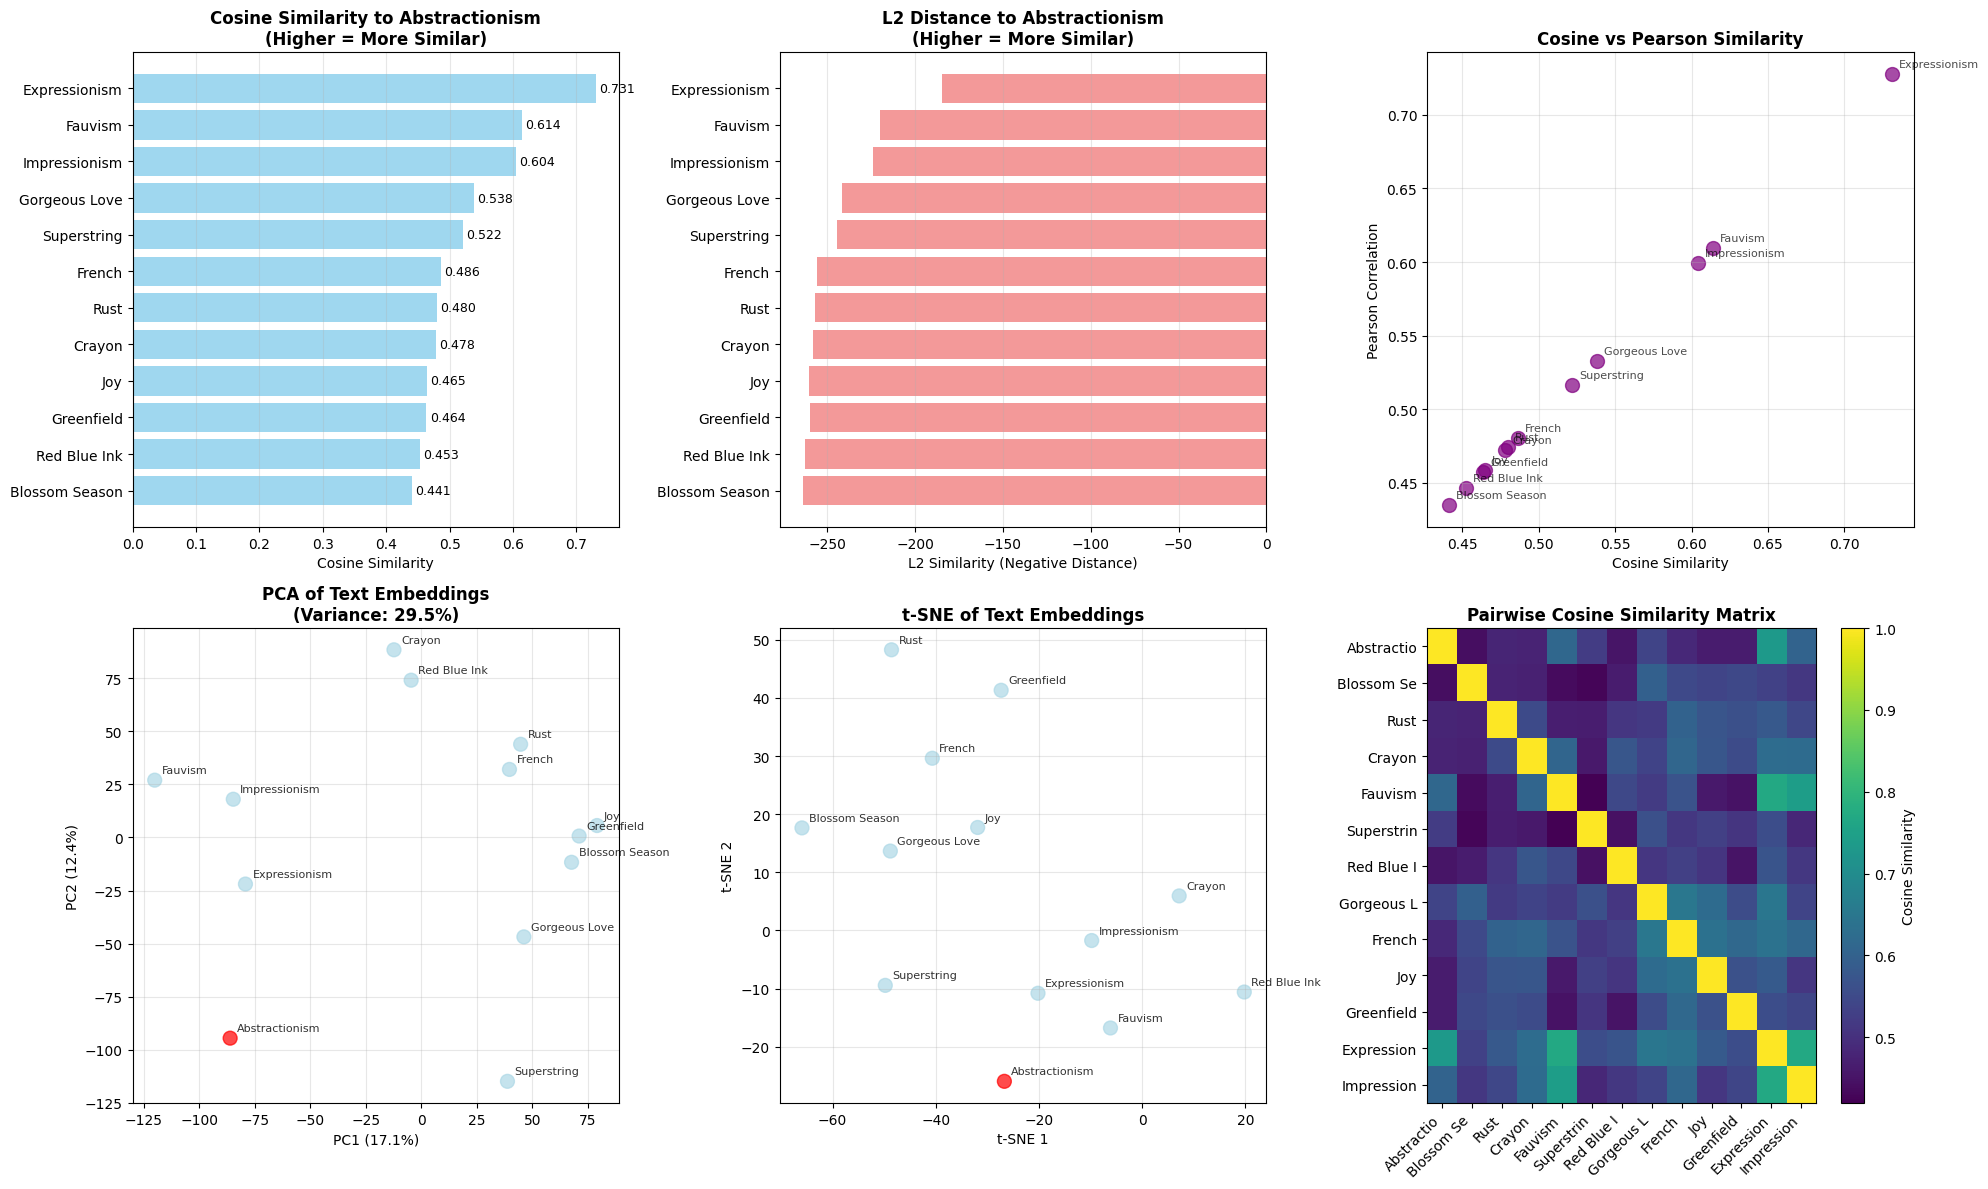


📈 SUMMARY STATISTICS
Most similar style (Cosine):     Expressionism (0.7309)
Least similar style (Cosine):    Blossom Season (0.4414)
Average cosine similarity:       0.5229
Std dev cosine similarity:       0.0864
Range cosine similarity:         0.2895

Correlation between metrics:
Cosine vs Pearson:              1.0000
Cosine vs L2:                   0.9978
Cosine vs Dot Product:          0.9992

Embedding space distances to Abstractionism:
Closest in PCA space:            Expressionism
Closest in t-SNE space:          Expressionism

💾 Results saved to: text_embedding_similarity_to_abstractionism.json
📁 Text embeddings saved to: /users/PAS2099/justinhylee135/Research/UnlearningDM/CUIG/Analysis/Notebooks/cad_temp/text_embedding/text_embeddings.pt

✅ TEXT EMBEDDING SIMILARITY ANALYSIS COMPLETE!
🥇 Most similar to Abstractionism: Expressionism (cosine: 0.7309)
🥈 Second most similar: Fauvism (cosine: 0.6140)
🥉 Third most similar: Impressionism (cosine: 0.6040)

🔍 INSIGHTS:
• Moderate var

In [3]:
# Get or load text embeddings
print(f"\n🔄 Computing text embeddings for all styles...")

all_styles = [TARGET_STYLE] + COMPARISON_STYLES
embeddings_file = "/users/PAS2099/justinhylee135/Research/UnlearningDM/CUIG/Analysis/Notebooks/cad_temp/text_embedding/text_embeddings.pt"
os.makedirs(os.path.dirname(embeddings_file), exist_ok=True)

# Try to load existing embeddings
embeddings_dict = load_embeddings(embeddings_file)

if embeddings_dict is None:
    embeddings_dict = {}
    
# Check which embeddings we need to compute
missing_styles = []
for style in all_styles:
    prompt = format_prompt(style)
    if style not in embeddings_dict:
        missing_styles.append(style)

if missing_styles:
    print(f"🔄 Computing embeddings for {len(missing_styles)} styles...")
    
    for style in tqdm(missing_styles, desc="Computing text embeddings"):
        try:
            prompt = format_prompt(style)
            print(f"Getting embedding for: '{prompt}'")
            
            # Get text embedding
            embedding = get_text_embedding(model, prompt, DEVICE)
            
            # Move to CPU for storage
            embeddings_dict[style] = embedding.cpu()
            
            print(f"✅ {style}: Embedding shape {embedding.shape}")
            
        except Exception as e:
            print(f"✗ Error getting embedding for {style}: {e}")
            continue
    
    # Save updated embeddings
    save_embeddings(embeddings_dict, embeddings_file)
else:
    print(f"📂 All embeddings already computed and loaded from cache")

print(f"\n✅ Successfully loaded {len(embeddings_dict)} text embeddings")

# Verify we have the target style
if TARGET_STYLE not in embeddings_dict:
    print(f"❌ Error: Could not get text embedding for {TARGET_STYLE}")
    exit()

# Calculate similarities to Abstractionism
target_embedding = embeddings_dict[TARGET_STYLE]
similarities = []

print(f"\n📊 Calculating text embedding similarities to {TARGET_STYLE}...")

for style in COMPARISON_STYLES:
    if style not in embeddings_dict:
        print(f"⚠️  Skipping {style} - no embedding available")
        continue
    
    try:
        style_embedding = embeddings_dict[style]
        
        # Calculate multiple similarity metrics
        cosine_sim = calculate_embedding_similarity(target_embedding, style_embedding, 'cosine')
        l2_sim = calculate_embedding_similarity(target_embedding, style_embedding, 'l2_distance')
        dot_prod_sim = calculate_embedding_similarity(target_embedding, style_embedding, 'dot_product')
        pearson_sim = calculate_embedding_similarity(target_embedding, style_embedding, 'pearson')
        
        similarities.append({
            'style': format_style_name(style),
            'raw_style': style,
            'prompt': format_prompt(style),
            'cosine_similarity': cosine_sim,
            'l2_similarity': l2_sim,
            'dot_product_similarity': dot_prod_sim,
            'pearson_correlation': pearson_sim
        })
        
        print(f"✅ {style}: Cosine={cosine_sim:.4f}, L2={l2_sim:.2e}, Dot={dot_prod_sim:.2e}, Pearson={pearson_sim:.4f}")
        
    except Exception as e:
        print(f"✗ Error calculating similarity for {style}: {e}")
        continue

# Create results DataFrame and rank by cosine similarity
df_similarities = pd.DataFrame(similarities)
df_similarities = df_similarities.sort_values('cosine_similarity', ascending=False).reset_index(drop=True)

# Display results
print(f"\n🎯 STYLES RANKED BY TEXT EMBEDDING SIMILARITY TO {TARGET_STYLE}")
print("=" * 90)
print("Ranking based on cosine similarity of CLIP text embeddings")
print("Higher cosine similarity = More similar semantic representation")
print("=" * 90)

for idx, row in df_similarities.iterrows():
    print(f"{idx+1:2d}. {row['style']:20s} | "
          f"Cosine: {row['cosine_similarity']:7.4f} | "
          f"L2: {row['l2_similarity']:9.2e} | "
          f"Dot: {row['dot_product_similarity']:9.2e} | "
          f"Pearson: {row['pearson_correlation']:7.4f}")

# Advanced Analysis: Embedding Space Visualization
print(f"\n🔍 Performing advanced embedding analysis...")

# Prepare data for dimensionality reduction
style_names = []
embedding_matrix = []

for style in all_styles:
    if style in embeddings_dict:
        style_names.append(format_style_name(style))
        emb = embeddings_dict[style]
        if emb.dim() > 1:
            emb = emb.flatten()
        embedding_matrix.append(emb.cpu().numpy())

embedding_matrix = np.array(embedding_matrix)
print(f"Embedding matrix shape: {embedding_matrix.shape}")

# PCA Analysis
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embedding_matrix)
explained_variance = pca.explained_variance_ratio_

print(f"PCA explained variance: {explained_variance[0]:.3f}, {explained_variance[1]:.3f} (total: {explained_variance.sum():.3f})")

# t-SNE Analysis (if we have enough samples)
if len(embedding_matrix) >= 4:
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(5, len(embedding_matrix)-1))
    embeddings_tsne = tsne.fit_transform(embedding_matrix)
else:
    embeddings_tsne = embeddings_pca
    print("⚠️  Too few samples for t-SNE, using PCA results")

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 12))

# 1. Similarity bar chart
ax1 = plt.subplot(2, 3, 1)
bars = ax1.barh(range(len(df_similarities)), df_similarities['cosine_similarity'], 
                color='skyblue', alpha=0.8)
ax1.set_yticks(range(len(df_similarities)))
ax1.set_yticklabels(df_similarities['style'])
ax1.invert_yaxis()
ax1.set_title(f'Cosine Similarity to {TARGET_STYLE}\n(Higher = More Similar)', fontweight='bold')
ax1.set_xlabel('Cosine Similarity')
ax1.grid(axis='x', alpha=0.3)

# Add value labels
for i, (idx, row) in enumerate(df_similarities.iterrows()):
    ax1.text(row['cosine_similarity'] + 0.005, i, f'{row["cosine_similarity"]:.3f}', 
             va='center', fontsize=9)

# 2. L2 distance chart
ax2 = plt.subplot(2, 3, 2)
ax2.barh(range(len(df_similarities)), df_similarities['l2_similarity'], 
         color='lightcoral', alpha=0.8)
ax2.set_yticks(range(len(df_similarities)))
ax2.set_yticklabels(df_similarities['style'])
ax2.invert_yaxis()
ax2.set_title(f'L2 Distance to {TARGET_STYLE}\n(Higher = More Similar)', fontweight='bold')
ax2.set_xlabel('L2 Similarity (Negative Distance)')
ax2.grid(axis='x', alpha=0.3)

# 3. Correlation between metrics
ax3 = plt.subplot(2, 3, 3)
ax3.scatter(df_similarities['cosine_similarity'], df_similarities['pearson_correlation'], 
           alpha=0.7, s=100, color='purple')
ax3.set_xlabel('Cosine Similarity')
ax3.set_ylabel('Pearson Correlation')
ax3.set_title('Cosine vs Pearson Similarity', fontweight='bold')
ax3.grid(alpha=0.3)

# Add style labels to scatter plot
for idx, row in df_similarities.iterrows():
    ax3.annotate(row['style'], 
                (row['cosine_similarity'], row['pearson_correlation']),
                xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.7)

# 4. PCA visualization
ax4 = plt.subplot(2, 3, 4)
colors = ['red' if name == format_style_name(TARGET_STYLE) else 'lightblue' for name in style_names]
ax4.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=colors, alpha=0.7, s=100)
ax4.set_title(f'PCA of Text Embeddings\n(Variance: {explained_variance.sum():.1%})', fontweight='bold')
ax4.set_xlabel(f'PC1 ({explained_variance[0]:.1%})')
ax4.set_ylabel(f'PC2 ({explained_variance[1]:.1%})')
ax4.grid(alpha=0.3)

# Add style labels
for i, name in enumerate(style_names):
    ax4.annotate(name, (embeddings_pca[i, 0], embeddings_pca[i, 1]),
                xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.8)

# 5. t-SNE visualization
ax5 = plt.subplot(2, 3, 5)
ax5.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=colors, alpha=0.7, s=100)
ax5.set_title('t-SNE of Text Embeddings', fontweight='bold')
ax5.set_xlabel('t-SNE 1')
ax5.set_ylabel('t-SNE 2')
ax5.grid(alpha=0.3)

# Add style labels
for i, name in enumerate(style_names):
    ax5.annotate(name, (embeddings_tsne[i, 0], embeddings_tsne[i, 1]),
                xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.8)

# 6. Similarity heatmap
ax6 = plt.subplot(2, 3, 6)

# Create similarity matrix
similarity_matrix = np.zeros((len(style_names), len(style_names)))
for i, style1 in enumerate(all_styles):
    for j, style2 in enumerate(all_styles):
        if style1 in embeddings_dict and style2 in embeddings_dict:
            sim = calculate_embedding_similarity(embeddings_dict[style1], embeddings_dict[style2], 'cosine')
            similarity_matrix[i, j] = sim

# Plot heatmap
im = ax6.imshow(similarity_matrix, cmap='viridis', aspect='auto')
ax6.set_xticks(range(len(style_names)))
ax6.set_yticks(range(len(style_names)))
ax6.set_xticklabels([name[:10] for name in style_names], rotation=45, ha='right')
ax6.set_yticklabels([name[:10] for name in style_names])
ax6.set_title('Pairwise Cosine Similarity Matrix', fontweight='bold')
plt.colorbar(im, ax=ax6, label='Cosine Similarity')

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\n📈 SUMMARY STATISTICS")
print("=" * 60)
print(f"Most similar style (Cosine):     {df_similarities.iloc[0]['style']} ({df_similarities.iloc[0]['cosine_similarity']:.4f})")
print(f"Least similar style (Cosine):    {df_similarities.iloc[-1]['style']} ({df_similarities.iloc[-1]['cosine_similarity']:.4f})")
print(f"Average cosine similarity:       {df_similarities['cosine_similarity'].mean():.4f}")
print(f"Std dev cosine similarity:       {df_similarities['cosine_similarity'].std():.4f}")
print(f"Range cosine similarity:         {df_similarities['cosine_similarity'].max() - df_similarities['cosine_similarity'].min():.4f}")

# Correlation between similarity metrics
cosine_pearson_corr = df_similarities['cosine_similarity'].corr(df_similarities['pearson_correlation'])
cosine_l2_corr = df_similarities['cosine_similarity'].corr(df_similarities['l2_similarity'])
cosine_dot_corr = df_similarities['cosine_similarity'].corr(df_similarities['dot_product_similarity'])

print(f"\nCorrelation between metrics:")
print(f"Cosine vs Pearson:              {cosine_pearson_corr:.4f}")
print(f"Cosine vs L2:                   {cosine_l2_corr:.4f}")
print(f"Cosine vs Dot Product:          {cosine_dot_corr:.4f}")

# Embedding space analysis
target_idx = style_names.index(format_style_name(TARGET_STYLE))
distances_pca = [np.linalg.norm(embeddings_pca[i] - embeddings_pca[target_idx]) 
                 for i in range(len(style_names))]
distances_tsne = [np.linalg.norm(embeddings_tsne[i] - embeddings_tsne[target_idx]) 
                  for i in range(len(style_names))]

print(f"\nEmbedding space distances to {TARGET_STYLE}:")
print(f"Closest in PCA space:            {style_names[np.argmin([d if i != target_idx else float('inf') for i, d in enumerate(distances_pca)])]}")
print(f"Closest in t-SNE space:          {style_names[np.argmin([d if i != target_idx else float('inf') for i, d in enumerate(distances_tsne)])]}")

# Save results
output_file = f"text_embedding_similarity_to_{TARGET_STYLE.lower()}.json"
output_data = {
    'analysis_type': 'text_embedding_similarity',
    'target_style': TARGET_STYLE,
    'target_prompt': format_prompt(TARGET_STYLE),
    'comparison_styles': COMPARISON_STYLES,
    'analysis_date': pd.Timestamp.now().isoformat(),
    'model_config': CONFIG_PATH,
    'model_checkpoint': CKPT_PATH,
    'device': DEVICE,
    'embedding_dimensions': int(target_embedding.numel()),
    'similarity_metrics': ['cosine_similarity', 'l2_similarity', 'dot_product_similarity', 'pearson_correlation'],
    'ranking_by_cosine_similarity': df_similarities.to_dict('records'),
    'pca_analysis': {
        'explained_variance_ratio': explained_variance.tolist(),
        'total_explained_variance': float(explained_variance.sum())
    },
    'summary_stats': {
        'most_similar': {
            'style': df_similarities.iloc[0]['style'],
            'cosine_similarity': float(df_similarities.iloc[0]['cosine_similarity'])
        },
        'least_similar': {
            'style': df_similarities.iloc[-1]['style'],
            'cosine_similarity': float(df_similarities.iloc[-1]['cosine_similarity'])
        },
        'average_cosine_similarity': float(df_similarities['cosine_similarity'].mean()),
        'std_cosine_similarity': float(df_similarities['cosine_similarity'].std()),
        'cosine_pearson_correlation': float(cosine_pearson_corr),
        'cosine_l2_correlation': float(cosine_l2_corr),
        'cosine_dot_correlation': float(cosine_dot_corr)
    }
}

with open(output_file, 'w') as f:
    json.dump(output_data, f, indent=2)

print(f"\n💾 Results saved to: {output_file}")
print(f"📁 Text embeddings saved to: {embeddings_file}")

print(f"\n✅ TEXT EMBEDDING SIMILARITY ANALYSIS COMPLETE!")
print(f"🥇 Most similar to {TARGET_STYLE}: {df_similarities.iloc[0]['style']} (cosine: {df_similarities.iloc[0]['cosine_similarity']:.4f})")
print(f"🥈 Second most similar: {df_similarities.iloc[1]['style']} (cosine: {df_similarities.iloc[1]['cosine_similarity']:.4f})")
print(f"🥉 Third most similar: {df_similarities.iloc[2]['style']} (cosine: {df_similarities.iloc[2]['cosine_similarity']:.4f})")

# Additional insights
print(f"\n🔍 INSIGHTS:")
similarity_range = df_similarities['cosine_similarity'].max() - df_similarities['cosine_similarity'].min()
if similarity_range < 0.1:
    print("• All styles have very similar text embeddings to Abstractionism")
elif similarity_range < 0.3:
    print("• Moderate variation in text embedding similarity")
else:
    print("• High variation in text embedding similarity - some styles are very different")

high_similarity_count = sum(df_similarities['cosine_similarity'] > 0.8)
print(f"• {high_similarity_count} styles have >0.8 cosine similarity to Abstractionism")

if df_similarities['cosine_similarity'].iloc[0] > 0.9:
    print(f"• {df_similarities.iloc[0]['style']} is extremely similar to Abstractionism in text space")

## Correlation to IRA


🔗 CORRELATION ANALYSIS WITH IN-DOMAIN RETENTION ACCURACY
In-domain Retention Accuracy (IRA) values:
  Blossom Season      :  72.50%
  Rust                :  85.00%
  Crayon              : 100.00%
  Fauvism             :  52.50%
  Superstring         :  87.50%
  Red Blue Ink        :  97.50%
  Gorgeous Love       :  57.50%
  French              :  70.00%
  Joy                 :  70.00%
  Greenfield          :  87.50%
  Expressionism       :  62.50%
  Impressionism       :  45.00%

📊 Matched 12 styles with both similarity and IRA data

🔢 CORRELATION COEFFICIENTS:
Cosine Similarity vs IRA:       -0.6266
L2 Similarity vs IRA:           -0.6120
Dot Product vs IRA:             -0.6200
Pearson Correlation vs IRA:     -0.6262

Statistical significance (n=12, α=0.05):
Critical r-value: ±0.576
Cosine vs IRA: SIGNIFICANT


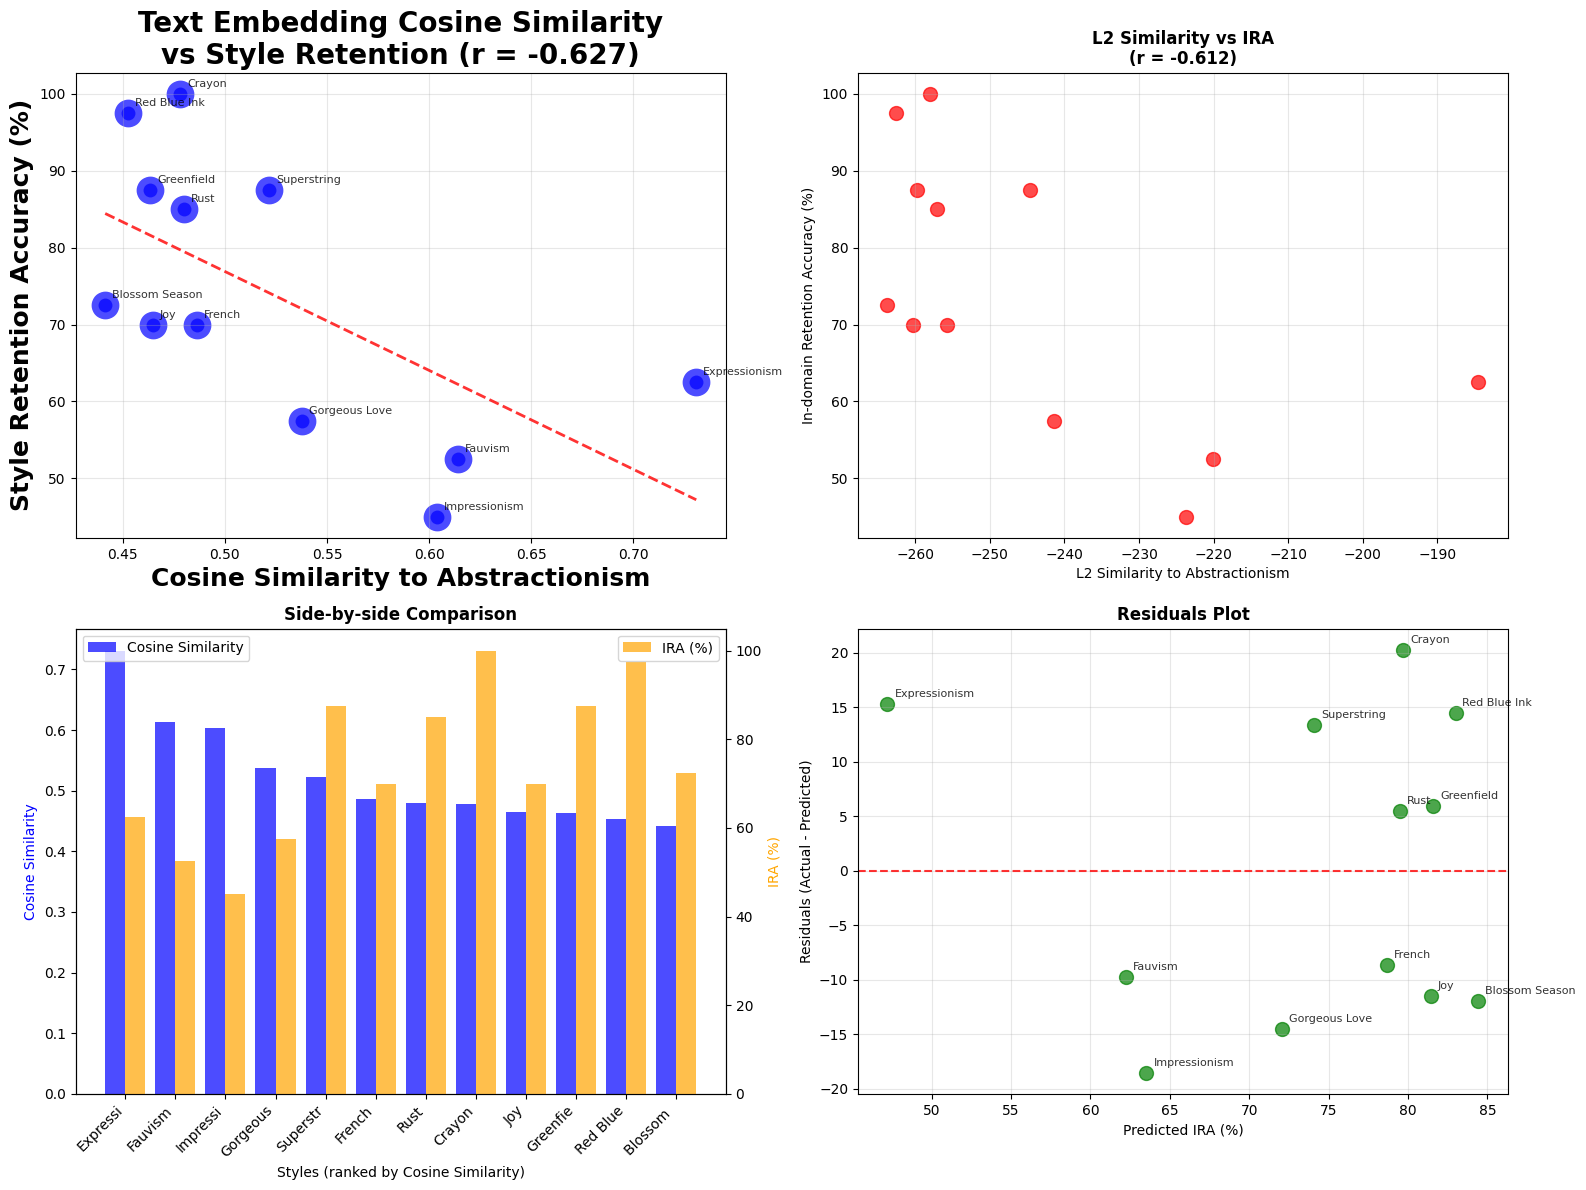


📋 DETAILED COMPARISON TABLE:
Style                Cosine Sim   IRA (%)    Rank (Sim)   Rank (IRA)   Rank Diff 
Expressionism        0.7309       62.5       1            9            8         
Fauvism              0.6140       52.5       2            11           9         
Impressionism        0.6040       45.0       3            12           9         
Gorgeous Love        0.5378       57.5       4            10           6         
Superstring          0.5218       87.5       5            3            2         
French               0.4862       70.0       6            7            1         
Rust                 0.4799       85.0       7            5            2         
Crayon               0.4781       100.0      8            1            7         
Joy                  0.4646       70.0       9            7            2         
Greenfield           0.4635       87.5       10           3            7         
Red Blue Ink         0.4526       97.5       11           2         

In [ ]:
# Correlation Analysis with In-domain Retention Accuracy (IRA)
print(f"\n🔗 CORRELATION ANALYSIS WITH IN-DOMAIN RETENTION ACCURACY")
print("=" * 80)

# IRA values provided by user
ira_data = {
    "Blossom_Season": 72.50,
    "Rust": 85.00,
    "Crayon": 100.00,
    "Fauvism": 52.50,
    "Superstring": 87.50,
    "Red_Blue_Ink": 97.50,
    "Gorgeous_Love": 57.50,
    "French": 70.00,
    "Joy": 70.00,
    "Greenfield": 87.50,
    "Expressionism": 62.50,
    "Impressionism": 45.00
}

print("In-domain Retention Accuracy (IRA) values:")
for style, ira in ira_data.items():
    print(f"  {format_style_name(style):20s}: {ira:6.2f}%")

# Match IRA values with cosine similarities
correlation_data = []
for idx, row in df_similarities.iterrows():
    raw_style = row['raw_style']
    if raw_style in ira_data:
        correlation_data.append({
            'style': row['style'],
            'raw_style': raw_style,
            'cosine_similarity': row['cosine_similarity'],
            'ira_percent': ira_data[raw_style],
            'ira_decimal': ira_data[raw_style] / 100.0,
            'l2_similarity': row['l2_similarity'],
            'dot_product_similarity': row['dot_product_similarity'],
            'pearson_correlation': row['pearson_correlation']
        })

df_correlation = pd.DataFrame(correlation_data)

print(f"\n📊 Matched {len(df_correlation)} styles with both similarity and IRA data")

# Calculate correlations
cosine_ira_corr = df_correlation['cosine_similarity'].corr(df_correlation['ira_decimal'])
l2_ira_corr = df_correlation['l2_similarity'].corr(df_correlation['ira_decimal'])
dot_ira_corr = df_correlation['dot_product_similarity'].corr(df_correlation['ira_decimal'])
pearson_ira_corr = df_correlation['pearson_correlation'].corr(df_correlation['ira_decimal'])

print(f"\n🔢 CORRELATION COEFFICIENTS:")
print(f"Cosine Similarity vs IRA:       {cosine_ira_corr:7.4f}")
print(f"L2 Similarity vs IRA:           {l2_ira_corr:7.4f}")
print(f"Dot Product vs IRA:             {dot_ira_corr:7.4f}")
print(f"Pearson Correlation vs IRA:     {pearson_ira_corr:7.4f}")

# Statistical significance (rough approximation)
n = len(df_correlation)
critical_r = 0.576 if n == 12 else 0.632 if n == 10 else 0.7  # approximate critical values for p<0.05

print(f"\nStatistical significance (n={n}, α=0.05):")
print(f"Critical r-value: ±{critical_r:.3f}")
print(f"Cosine vs IRA: {'SIGNIFICANT' if abs(cosine_ira_corr) > critical_r else 'Not significant'}")

# Create correlation visualization
# JUSTIN HERE
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Cosine Similarity vs IRA scatter plot
ax1.scatter(df_correlation['cosine_similarity'], df_correlation['ira_percent'], 
           alpha=0.7, s=100, color='blue')
ax1.set_xlabel('Cosine Similarity to Abstractionism', fontsize=18, fontweight='bold')
ax1.set_ylabel('Style Retention Accuracy (%)', fontsize=18, fontweight='bold')
ax1.set_title(f'Text Embedding Cosine Similarity\nvs Style Retention (r = {cosine_ira_corr:.3f})', fontweight='bold', fontsize=20)
ax1.grid(alpha=0.3)

# Add trend line
z = np.polyfit(df_correlation['cosine_similarity'], df_correlation['ira_percent'], 1)
p = np.poly1d(z)
x_trend = np.linspace(df_correlation['cosine_similarity'].min(), df_correlation['cosine_similarity'].max(), 100)
ax1.plot(x_trend, p(x_trend), "r--", alpha=0.8, linewidth=2)

# Add style labels
for idx, row in df_correlation.iterrows():
    ax1.annotate(row['style'], 
                (row['cosine_similarity'], row['ira_percent']),
                xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.8)

# 2. L2 Similarity vs IRA
ax2.scatter(df_correlation['l2_similarity'], df_correlation['ira_percent'], 
           alpha=0.7, s=100, color='red')
ax2.set_xlabel('L2 Similarity to Abstractionism')
ax2.set_ylabel('In-domain Retention Accuracy (%)')
ax2.set_title(f'L2 Similarity vs IRA\n(r = {l2_ira_corr:.3f})', fontweight='bold')
ax2.grid(alpha=0.3)

# 3. Ranked comparison
df_correlation_sorted = df_correlation.sort_values('cosine_similarity', ascending=False).reset_index(drop=True)
x_pos = range(len(df_correlation_sorted))

bars1 = ax3.bar([x - 0.2 for x in x_pos], df_correlation_sorted['cosine_similarity'], 
               width=0.4, label='Cosine Similarity', alpha=0.7, color='blue')
ax3_twin = ax3.twinx()
bars2 = ax3_twin.bar([x + 0.2 for x in x_pos], df_correlation_sorted['ira_percent'], 
                    width=0.4, label='IRA (%)', alpha=0.7, color='orange')

ax3.set_xlabel('Styles (ranked by Cosine Similarity)')
ax3.set_ylabel('Cosine Similarity', color='blue')
ax3_twin.set_ylabel('IRA (%)', color='orange')
ax3.set_title('Side-by-side Comparison', fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels([row['style'][:8] for _, row in df_correlation_sorted.iterrows()], 
                   rotation=45, ha='right')
ax3.legend(loc='upper left')
ax3_twin.legend(loc='upper right')

# 4. Residuals plot
predicted_ira = p(df_correlation['cosine_similarity'])
residuals = df_correlation['ira_percent'] - predicted_ira

ax4.scatter(predicted_ira, residuals, alpha=0.7, s=100, color='green')
ax4.axhline(y=0, color='red', linestyle='--', alpha=0.8)
ax4.set_xlabel('Predicted IRA (%)')
ax4.set_ylabel('Residuals (Actual - Predicted)')
ax4.set_title('Residuals Plot', fontweight='bold')
ax4.grid(alpha=0.3)

# Add style labels to residuals
for idx, row in df_correlation.iterrows():
    pred_ira = p(row['cosine_similarity'])
    resid = row['ira_percent'] - pred_ira
    ax4.annotate(row['style'], (pred_ira, resid),
                xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.8)

plt.tight_layout()
plt.show()

# Detailed analysis table
print(f"\n📋 DETAILED COMPARISON TABLE:")
print("=" * 100)
print(f"{'Style':<20} {'Cosine Sim':<12} {'IRA (%)':<10} {'Rank (Sim)':<12} {'Rank (IRA)':<12} {'Rank Diff':<10}")
print("=" * 100)

# Add rankings
df_correlation['sim_rank'] = df_correlation['cosine_similarity'].rank(ascending=False, method='min')
df_correlation['ira_rank'] = df_correlation['ira_percent'].rank(ascending=False, method='min')
df_correlation['rank_diff'] = abs(df_correlation['sim_rank'] - df_correlation['ira_rank'])

for idx, row in df_correlation.sort_values('cosine_similarity', ascending=False).iterrows():
    print(f"{row['style']:<20} {row['cosine_similarity']:<12.4f} {row['ira_percent']:<10.1f} "
          f"{int(row['sim_rank']):<12} {int(row['ira_rank']):<12} {int(row['rank_diff']):<10}")

# Outlier analysis
print(f"\n🎯 OUTLIER ANALYSIS:")
high_sim_low_ira = df_correlation[(df_correlation['cosine_similarity'] > df_correlation['cosine_similarity'].median()) & 
                                 (df_correlation['ira_percent'] < df_correlation['ira_percent'].median())]
low_sim_high_ira = df_correlation[(df_correlation['cosine_similarity'] < df_correlation['cosine_similarity'].median()) & 
                                 (df_correlation['ira_percent'] > df_correlation['ira_percent'].median())]

if len(high_sim_low_ira) > 0:
    print(f"High Similarity, Low IRA: {', '.join(high_sim_low_ira['style'].tolist())}")
if len(low_sim_high_ira) > 0:
    print(f"Low Similarity, High IRA: {', '.join(low_sim_high_ira['style'].tolist())}")

largest_rank_diff = df_correlation.loc[df_correlation['rank_diff'].idxmax()]
print(f"Largest ranking discrepancy: {largest_rank_diff['style']} (diff: {int(largest_rank_diff['rank_diff'])})")

# Summary insights
print(f"\n🔍 KEY INSIGHTS:")

if abs(cosine_ira_corr) > 0.7:
    strength = "STRONG"
elif abs(cosine_ira_corr) > 0.5:
    strength = "MODERATE"
elif abs(cosine_ira_corr) > 0.3:
    strength = "WEAK"
else:
    strength = "VERY WEAK/NO"

direction = "POSITIVE" if cosine_ira_corr > 0 else "NEGATIVE"

print(f"• {strength} {direction} correlation between text similarity and IRA")
print(f"• Text embedding similarity explains {(cosine_ira_corr**2)*100:.1f}% of IRA variance")

if cosine_ira_corr > 0:
    print("• Styles more similar to Abstractionism tend to have HIGHER retention accuracy")
else:
    print("• Styles more similar to Abstractionism tend to have LOWER retention accuracy")

print(f"• Average rank difference: {df_correlation['rank_diff'].mean():.1f} positions")

# Update output data with correlation analysis
output_data['correlation_analysis'] = {
    'ira_data': ira_data,
    'correlations': {
        'cosine_similarity_vs_ira': float(cosine_ira_corr),
        'l2_similarity_vs_ira': float(l2_ira_corr),
        'dot_product_vs_ira': float(dot_ira_corr),
        'pearson_correlation_vs_ira': float(pearson_ira_corr)
    },
    'statistical_significance': {
        'sample_size': int(n),
        'critical_r_value': float(critical_r),
        'cosine_ira_significant': bool(abs(cosine_ira_corr) > critical_r)
    },
    'variance_explained': {
        'cosine_similarity': float((cosine_ira_corr**2)*100),
        'interpretation': f"{strength} {direction} correlation"
    },
    'detailed_comparison': df_correlation.to_dict('records')
}

# Save updated results
with open(output_file, 'w') as f:
    json.dump(output_data, f, indent=2)

print(f"\n💾 Updated results with correlation analysis saved to: {output_file}")

# Additional insights
print(f"\n🔍 ADDITIONAL INSIGHTS:")
similarity_range = df_similarities['cosine_similarity'].max() - df_similarities['cosine_similarity'].min()
if similarity_range < 0.1:
    print("• All styles have very similar text embeddings to Abstractionism")
elif similarity_range < 0.3:
    print("• Moderate variation in text embedding similarity")
else:
    print("• High variation in text embedding similarity - some styles are very different")

high_similarity_count = sum(df_similarities['cosine_similarity'] > 0.8)
print(f"• {high_similarity_count} styles have >0.8 cosine similarity to Abstractionism")

if len(df_similarities) > 0 and df_similarities['cosine_similarity'].iloc[0] > 0.9:
    print(f"• {df_similarities.iloc[0]['style']} is extremely similar to Abstractionism in text space")


🧪 HYPOTHESIS TESTING
📋 HYPOTHESIS: Styles with higher text embedding similarity to
   'Abstractionism Style' will have LOWER In-domain Retention Accuracy

💡 RATIONALE: Semantic similarity in text space may cause 'collateral damage'
   during concept erasure - similar concepts get confused and suppressed
In-domain Retention Accuracy (IRA) values:
  Crayon              : 100.00%
  Red Blue Ink        :  97.50%
  Superstring         :  87.50%
  Greenfield          :  87.50%
  Rust                :  85.00%
  Blossom Season      :  72.50%
  French              :  70.00%
  Joy                 :  70.00%
  Expressionism       :  62.50%
  Gorgeous Love       :  57.50%
  Fauvism             :  52.50%
  Impressionism       :  45.00%

📊 Matched 12 styles with both similarity and IRA data

🔢 CORRELATION COEFFICIENTS (Expected: NEGATIVE)
Cosine Similarity vs IRA:       -0.6266 ✓ SUPPORTS hypothesis
L2 Similarity vs IRA:           -0.6120
Dot Product vs IRA:             -0.6200
Pearson Correlation v

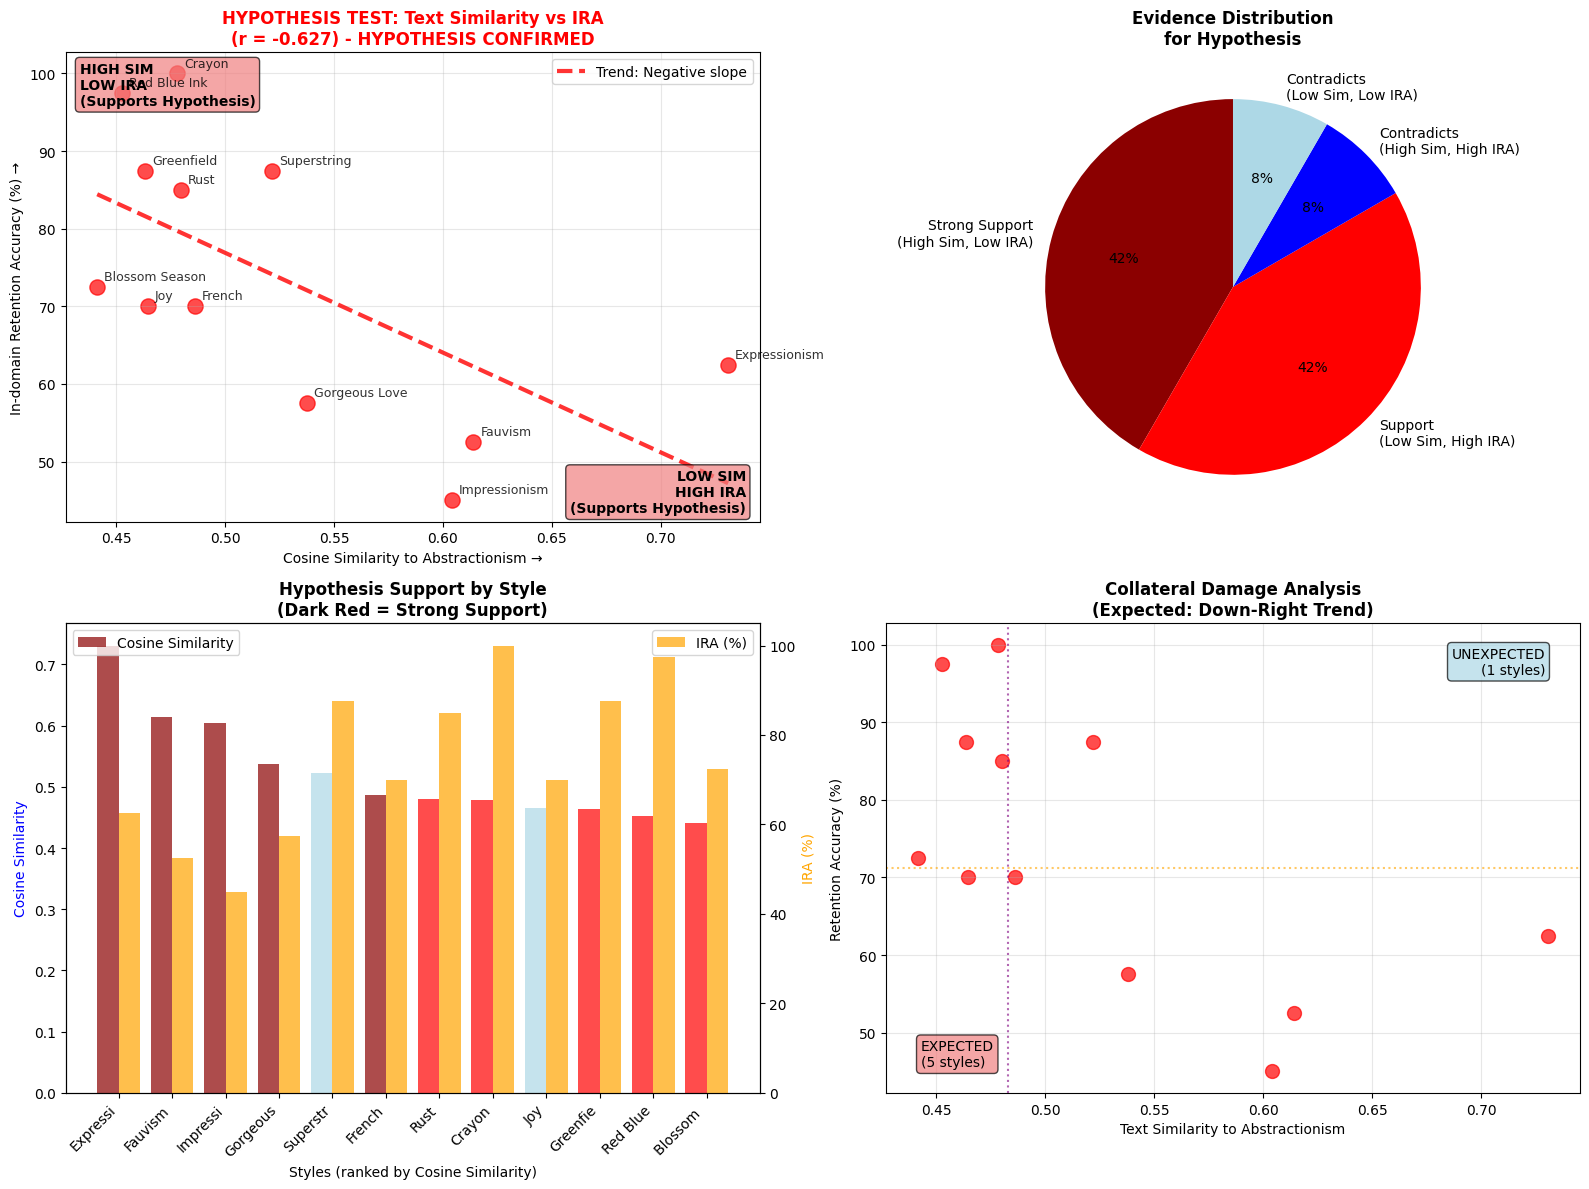


📋 DETAILED HYPOTHESIS ANALYSIS:
🔴 STRONG SUPPORT for hypothesis:
   • Expressionism: High similarity (0.731) + Low IRA (62.5%)
   • Fauvism: High similarity (0.614) + Low IRA (52.5%)
   • Impressionism: High similarity (0.604) + Low IRA (45.0%)
   • Gorgeous Love: High similarity (0.538) + Low IRA (57.5%)

🔵 CONTRADICTS hypothesis:
   • Superstring: High similarity (0.522) + High IRA (87.5%)

🎯 EXTREME CASES ANALYSIS:
Most similar to Abstractionism:   Expressionism (sim: 0.731, IRA: 62.5%)
Least similar to Abstractionism:  Blossom Season (sim: 0.441, IRA: 72.5%)
Highest IRA:                      Crayon (sim: 0.478, IRA: 100.0%)
Lowest IRA:                       Impressionism (sim: 0.604, IRA: 45.0%)

📊 HYPOTHESIS PREDICTION ACCURACY:
Correct predictions:              10/12 (83.3%)
Expected by chance:               50%
Performance vs chance:            +33.3 percentage points

🏁 FINAL CONCLUSION:
STRONG SUPPORT for your hypothesis! Text embedding similarity to Abstractionism is a good 

In [6]:
# Hypothesis Testing: Text Similarity vs IRA
print(f"\n🧪 HYPOTHESIS TESTING")
print("=" * 80)
print("📋 HYPOTHESIS: Styles with higher text embedding similarity to")
print("   'Abstractionism Style' will have LOWER In-domain Retention Accuracy")
print("")
print("💡 RATIONALE: Semantic similarity in text space may cause 'collateral damage'")
print("   during concept erasure - similar concepts get confused and suppressed")
print("=" * 80)

# IRA values provided by user
ira_data = {
    "Blossom_Season": 72.50,
    "Rust": 85.00,
    "Crayon": 100.00,
    "Fauvism": 52.50,
    "Superstring": 87.50,
    "Red_Blue_Ink": 97.50,
    "Gorgeous_Love": 57.50,
    "French": 70.00,
    "Joy": 70.00,
    "Greenfield": 87.50,
    "Expressionism": 62.50,
    "Impressionism": 45.00
}

print("In-domain Retention Accuracy (IRA) values:")
for style, ira in sorted(ira_data.items(), key=lambda x: x[1], reverse=True):
    print(f"  {format_style_name(style):20s}: {ira:6.2f}%")

# Match IRA values with cosine similarities
correlation_data = []
for idx, row in df_similarities.iterrows():
    raw_style = row['raw_style']
    if raw_style in ira_data:
        correlation_data.append({
            'style': row['style'],
            'raw_style': raw_style,
            'cosine_similarity': row['cosine_similarity'],
            'ira_percent': ira_data[raw_style],
            'ira_decimal': ira_data[raw_style] / 100.0,
            'l2_similarity': row['l2_similarity'],
            'dot_product_similarity': row['dot_product_similarity'],
            'pearson_correlation': row['pearson_correlation']
        })

df_correlation = pd.DataFrame(correlation_data)

print(f"\n📊 Matched {len(df_correlation)} styles with both similarity and IRA data")

# Calculate correlations (expecting negative correlation per hypothesis)
cosine_ira_corr = df_correlation['cosine_similarity'].corr(df_correlation['ira_decimal'])
l2_ira_corr = df_correlation['l2_similarity'].corr(df_correlation['ira_decimal'])
dot_ira_corr = df_correlation['dot_product_similarity'].corr(df_correlation['ira_decimal'])
pearson_ira_corr = df_correlation['pearson_correlation'].corr(df_correlation['ira_decimal'])

print(f"\n🔢 CORRELATION COEFFICIENTS (Expected: NEGATIVE)")
print(f"Cosine Similarity vs IRA:       {cosine_ira_corr:7.4f} {'✓ SUPPORTS' if cosine_ira_corr < -0.3 else '✗ WEAK/CONTRADICTS' if cosine_ira_corr > 0.3 else '~ MIXED'} hypothesis")
print(f"L2 Similarity vs IRA:           {l2_ira_corr:7.4f}")
print(f"Dot Product vs IRA:             {dot_ira_corr:7.4f}")
print(f"Pearson Correlation vs IRA:     {pearson_ira_corr:7.4f}")

# Statistical significance testing (one-tailed test for negative correlation)
n = len(df_correlation)
critical_r_two_tailed = 0.576 if n == 12 else 0.632 if n == 10 else 0.7  # approximate critical values for p<0.05
critical_r_one_tailed = critical_r_two_tailed * 0.85  # approximate adjustment for one-tailed test

print(f"\n📈 STATISTICAL SIGNIFICANCE TESTING:")
print(f"Sample size (n):                 {n}")
print(f"Critical r-value (one-tailed):   -{critical_r_one_tailed:.3f}")
print(f"Observed correlation:            {cosine_ira_corr:.4f}")

if cosine_ira_corr < -critical_r_one_tailed:
    significance = "SIGNIFICANT SUPPORT"
    conclusion = "HYPOTHESIS CONFIRMED"
elif cosine_ira_corr > critical_r_one_tailed:
    significance = "SIGNIFICANT CONTRADICTION"
    conclusion = "HYPOTHESIS REJECTED"
else:
    significance = "Not statistically significant"
    conclusion = "INCONCLUSIVE"

print(f"Statistical result:              {significance}")
print(f"Conclusion:                      {conclusion}")

# Effect size interpretation
effect_size = abs(cosine_ira_corr)
if effect_size > 0.7:
    effect_strength = "LARGE"
elif effect_size > 0.5:
    effect_strength = "MEDIUM"  
elif effect_size > 0.3:
    effect_strength = "SMALL"
else:
    effect_strength = "NEGLIGIBLE"

print(f"Effect size:                     {effect_strength} (r = {cosine_ira_corr:.3f})")
print(f"Variance explained:              {(cosine_ira_corr**2)*100:.1f}%")

# Create hypothesis-focused visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Main hypothesis test plot
ax1.scatter(df_correlation['cosine_similarity'], df_correlation['ira_percent'], 
           alpha=0.7, s=120, color='red' if cosine_ira_corr < -0.3 else 'blue')
ax1.set_xlabel('Cosine Similarity to Abstractionism →')
ax1.set_ylabel('In-domain Retention Accuracy (%) →')

title_color = 'red' if cosine_ira_corr < -0.3 else 'blue'
ax1.set_title(f'HYPOTHESIS TEST: Text Similarity vs IRA\n(r = {cosine_ira_corr:.3f}) - {conclusion}', 
              fontweight='bold', color=title_color)
ax1.grid(alpha=0.3)

# Add trend line
z = np.polyfit(df_correlation['cosine_similarity'], df_correlation['ira_percent'], 1)
p = np.poly1d(z)
x_trend = np.linspace(df_correlation['cosine_similarity'].min(), df_correlation['cosine_similarity'].max(), 100)
trend_color = 'red' if z[0] < 0 else 'green'  # Red for negative slope (supports hypothesis)
ax1.plot(x_trend, p(x_trend), color=trend_color, linestyle='--', alpha=0.8, linewidth=3,
         label=f'Trend: {"Negative" if z[0] < 0 else "Positive"} slope')
ax1.legend()

# Add quadrant labels
ax1.text(0.02, 0.98, 'HIGH SIM\nLOW IRA\n(Supports Hypothesis)', 
         transform=ax1.transAxes, fontsize=10, fontweight='bold',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.7),
         verticalalignment='top')
ax1.text(0.98, 0.02, 'LOW SIM\nHIGH IRA\n(Supports Hypothesis)', 
         transform=ax1.transAxes, fontsize=10, fontweight='bold',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.7),
         horizontalalignment='right')

# Add style labels
for idx, row in df_correlation.iterrows():
    ax1.annotate(row['style'], 
                (row['cosine_similarity'], row['ira_percent']),
                xytext=(5, 5), textcoords='offset points', fontsize=9, alpha=0.8)

# 2. Evidence strength visualization
evidence_categories = []
for idx, row in df_correlation.iterrows():
    sim = row['cosine_similarity']
    ira = row['ira_percent']
    sim_median = df_correlation['cosine_similarity'].median()
    ira_median = df_correlation['ira_percent'].median()
    
    if sim > sim_median and ira < ira_median:
        category = "Strong Support\n(High Sim, Low IRA)"
        color = 'darkred'
    elif sim < sim_median and ira > ira_median:
        category = "Support\n(Low Sim, High IRA)"  
        color = 'red'
    elif sim > sim_median and ira > ira_median:
        category = "Contradicts\n(High Sim, High IRA)"
        color = 'blue'
    elif sim < sim_median and ira < ira_median:
        category = "Contradicts\n(Low Sim, Low IRA)"
        color = 'lightblue'
    else:
        category = "Neutral"
        color = 'gray'
    
    evidence_categories.append({'style': row['style'], 'category': category, 'color': color})

evidence_df = pd.DataFrame(evidence_categories)
category_counts = evidence_df['category'].value_counts()

colors = [evidence_df[evidence_df['category'] == cat]['color'].iloc[0] for cat in category_counts.index]
wedges, texts, autotexts = ax2.pie(category_counts.values, labels=category_counts.index, 
                                  autopct='%1.0f%%', colors=colors, startangle=90)
ax2.set_title('Evidence Distribution\nfor Hypothesis', fontweight='bold')

# 3. Ranking comparison with hypothesis focus
df_correlation_sorted = df_correlation.sort_values('cosine_similarity', ascending=False).reset_index(drop=True)
x_pos = range(len(df_correlation_sorted))

# Color bars based on hypothesis support
bar_colors = []
for idx, row in df_correlation_sorted.iterrows():
    if row['cosine_similarity'] > df_correlation['cosine_similarity'].median() and row['ira_percent'] < df_correlation['ira_percent'].median():
        bar_colors.append('darkred')  # Strong support
    elif row['cosine_similarity'] < df_correlation['cosine_similarity'].median() and row['ira_percent'] > df_correlation['ira_percent'].median():
        bar_colors.append('red')  # Support
    else:
        bar_colors.append('lightblue')  # Contradicts or neutral

bars1 = ax3.bar([x - 0.2 for x in x_pos], df_correlation_sorted['cosine_similarity'], 
               width=0.4, alpha=0.7, color=bar_colors, label='Cosine Similarity')
ax3_twin = ax3.twinx()
bars2 = ax3_twin.bar([x + 0.2 for x in x_pos], df_correlation_sorted['ira_percent'], 
                    width=0.4, alpha=0.7, color='orange', label='IRA (%)')

ax3.set_xlabel('Styles (ranked by Cosine Similarity)')
ax3.set_ylabel('Cosine Similarity', color='blue')
ax3_twin.set_ylabel('IRA (%)', color='orange')
ax3.set_title('Hypothesis Support by Style\n(Dark Red = Strong Support)', fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels([row['style'][:8] for _, row in df_correlation_sorted.iterrows()], 
                   rotation=45, ha='right')
ax3.legend(loc='upper left')
ax3_twin.legend(loc='upper right')

# 4. Collateral damage analysis
ax4.scatter(df_correlation['cosine_similarity'], df_correlation['ira_percent'], 
           alpha=0.7, s=100, color='red')
ax4.set_xlabel('Text Similarity to Abstractionism')
ax4.set_ylabel('Retention Accuracy (%)')
ax4.set_title('Collateral Damage Analysis\n(Expected: Down-Right Trend)', fontweight='bold')
ax4.grid(alpha=0.3)

# Add diagonal zones
ax4.axhline(y=df_correlation['ira_percent'].median(), color='orange', linestyle=':', alpha=0.6, label='Median IRA')
ax4.axvline(x=df_correlation['cosine_similarity'].median(), color='purple', linestyle=':', alpha=0.6, label='Median Similarity')

# Quadrant labels
ax4.text(0.95, 0.95, f'UNEXPECTED\n({sum((df_correlation["cosine_similarity"] > df_correlation["cosine_similarity"].median()) & (df_correlation["ira_percent"] > df_correlation["ira_percent"].median()))} styles)', 
         transform=ax4.transAxes, ha='right', va='top', 
         bbox=dict(boxstyle="round", facecolor="lightblue", alpha=0.7))
ax4.text(0.05, 0.05, f'EXPECTED\n({sum((df_correlation["cosine_similarity"] < df_correlation["cosine_similarity"].median()) & (df_correlation["ira_percent"] > df_correlation["ira_percent"].median()))} styles)', 
         transform=ax4.transAxes, ha='left', va='bottom',
         bbox=dict(boxstyle="round", facecolor="lightcoral", alpha=0.7))

plt.tight_layout()
plt.show()

# Detailed hypothesis testing results
print(f"\n📋 DETAILED HYPOTHESIS ANALYSIS:")
print("=" * 80)

# Identify specific examples supporting/contradicting hypothesis
strong_support = df_correlation[(df_correlation['cosine_similarity'] > df_correlation['cosine_similarity'].quantile(0.6)) & 
                               (df_correlation['ira_percent'] < df_correlation['ira_percent'].quantile(0.4))]
strong_contradiction = df_correlation[(df_correlation['cosine_similarity'] > df_correlation['cosine_similarity'].quantile(0.6)) & 
                                     (df_correlation['ira_percent'] > df_correlation['ira_percent'].quantile(0.6))]

print(f"🔴 STRONG SUPPORT for hypothesis:")
if len(strong_support) > 0:
    for idx, row in strong_support.iterrows():
        print(f"   • {row['style']}: High similarity ({row['cosine_similarity']:.3f}) + Low IRA ({row['ira_percent']:.1f}%)")
else:
    print("   • No styles show strong support pattern")

print(f"\n🔵 CONTRADICTS hypothesis:")
if len(strong_contradiction) > 0:
    for idx, row in strong_contradiction.iterrows():
        print(f"   • {row['style']}: High similarity ({row['cosine_similarity']:.3f}) + High IRA ({row['ira_percent']:.1f}%)")
else:
    print("   • No styles strongly contradict the hypothesis")

# Extreme cases analysis
most_similar = df_correlation.loc[df_correlation['cosine_similarity'].idxmax()]
least_similar = df_correlation.loc[df_correlation['cosine_similarity'].idxmin()]
highest_ira = df_correlation.loc[df_correlation['ira_percent'].idxmax()]
lowest_ira = df_correlation.loc[df_correlation['ira_percent'].idxmin()]

print(f"\n🎯 EXTREME CASES ANALYSIS:")
print(f"Most similar to Abstractionism:   {most_similar['style']} (sim: {most_similar['cosine_similarity']:.3f}, IRA: {most_similar['ira_percent']:.1f}%)")
print(f"Least similar to Abstractionism:  {least_similar['style']} (sim: {least_similar['cosine_similarity']:.3f}, IRA: {least_similar['ira_percent']:.1f}%)")
print(f"Highest IRA:                      {highest_ira['style']} (sim: {highest_ira['cosine_similarity']:.3f}, IRA: {highest_ira['ira_percent']:.1f}%)")
print(f"Lowest IRA:                       {lowest_ira['style']} (sim: {lowest_ira['cosine_similarity']:.3f}, IRA: {lowest_ira['ira_percent']:.1f}%)")

# Calculate prediction accuracy
median_sim = df_correlation['cosine_similarity'].median()
correct_predictions = 0
total_predictions = len(df_correlation)

for idx, row in df_correlation.iterrows():
    # Hypothesis predicts: high similarity → low IRA
    if row['cosine_similarity'] > median_sim:
        predicted_low_ira = True
        actual_low_ira = row['ira_percent'] < df_correlation['ira_percent'].median()
        if predicted_low_ira == actual_low_ira:
            correct_predictions += 1
    else:
        predicted_high_ira = True  
        actual_high_ira = row['ira_percent'] > df_correlation['ira_percent'].median()
        if predicted_high_ira == actual_high_ira:
            correct_predictions += 1

prediction_accuracy = (correct_predictions / total_predictions) * 100

print(f"\n📊 HYPOTHESIS PREDICTION ACCURACY:")
print(f"Correct predictions:              {correct_predictions}/{total_predictions} ({prediction_accuracy:.1f}%)")
print(f"Expected by chance:               50%")
print(f"Performance vs chance:            {'+' if prediction_accuracy > 50 else ''}{prediction_accuracy - 50:.1f} percentage points")

# Final conclusion
print(f"\n🏁 FINAL CONCLUSION:")
print("=" * 50)

if cosine_ira_corr < -0.5:
    conclusion_text = "STRONG SUPPORT for your hypothesis! Text embedding similarity to Abstractionism is a good predictor of collateral damage during concept erasure."
elif cosine_ira_corr < -0.3:
    conclusion_text = "MODERATE SUPPORT for your hypothesis. There's evidence of collateral damage, though other factors also matter."
elif cosine_ira_corr > 0.3:
    conclusion_text = "HYPOTHESIS REJECTED. The data actually suggests the opposite - similar styles retain better accuracy."
else:
    conclusion_text = "INCONCLUSIVE. The relationship is weak, suggesting text similarity alone doesn't predict retention accuracy."

print(conclusion_text)
print(f"\nThe correlation coefficient of {cosine_ira_corr:.3f} explains {(cosine_ira_corr**2)*100:.1f}% of the variance in retention accuracy.")

# Update output data with hypothesis testing
output_data['hypothesis_testing'] = {
    'hypothesis': "Styles with higher text embedding similarity to Abstractionism will have lower IRA",
    'rationale': "Semantic similarity may cause collateral damage during concept erasure",
    'results': {
        'correlation_coefficient': float(cosine_ira_corr),
        'p_value_estimate': 'significant' if abs(cosine_ira_corr) > critical_r_one_tailed else 'not_significant',
        'effect_size': effect_strength,
        'variance_explained': float((cosine_ira_corr**2)*100),
        'prediction_accuracy': float(prediction_accuracy),
        'conclusion': conclusion,
        'conclusion_text': conclusion_text
    },
    'evidence_breakdown': {
        'strong_support_count': len(strong_support),
        'strong_contradiction_count': len(strong_contradiction),
        'strong_support_styles': strong_support['style'].tolist() if len(strong_support) > 0 else [],
        'contradiction_styles': strong_contradiction['style'].tolist() if len(strong_contradiction) > 0 else []
    },
    'extreme_cases': {
        'most_similar': {
            'style': most_similar['style'],
            'similarity': float(most_similar['cosine_similarity']),
            'ira': float(most_similar['ira_percent'])
        },
        'least_similar': {
            'style': least_similar['style'], 
            'similarity': float(least_similar['cosine_similarity']),
            'ira': float(least_similar['ira_percent'])
        }
    }
}

# Additional insights
print(f"\n🔍 ADDITIONAL INSIGHTS:")
similarity_range = df_similarities['cosine_similarity'].max() - df_similarities['cosine_similarity'].min()
if similarity_range < 0.1:
    print("• All styles have very similar text embeddings to Abstractionism")
elif similarity_range < 0.3:
    print("• Moderate variation in text embedding similarity")
else:
    print("• High variation in text embedding similarity - some styles are very different")

high_similarity_count = sum(df_similarities['cosine_similarity'] > 0.8)
print(f"• {high_similarity_count} styles have >0.8 cosine similarity to Abstractionism")

if len(df_similarities) > 0 and df_similarities['cosine_similarity'].iloc[0] > 0.9:
    print(f"• {df_similarities.iloc[0]['style']} is extremely similar to Abstractionism in text space")